In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d


import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/'
x1ds = np.hstack((glob.glob('{}*0_x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path)), glob.glob('{}*x1dsum.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37030_sx1.fits'],
      dtype='<U69')

/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37010_x1d.fits
G230L
512.5828


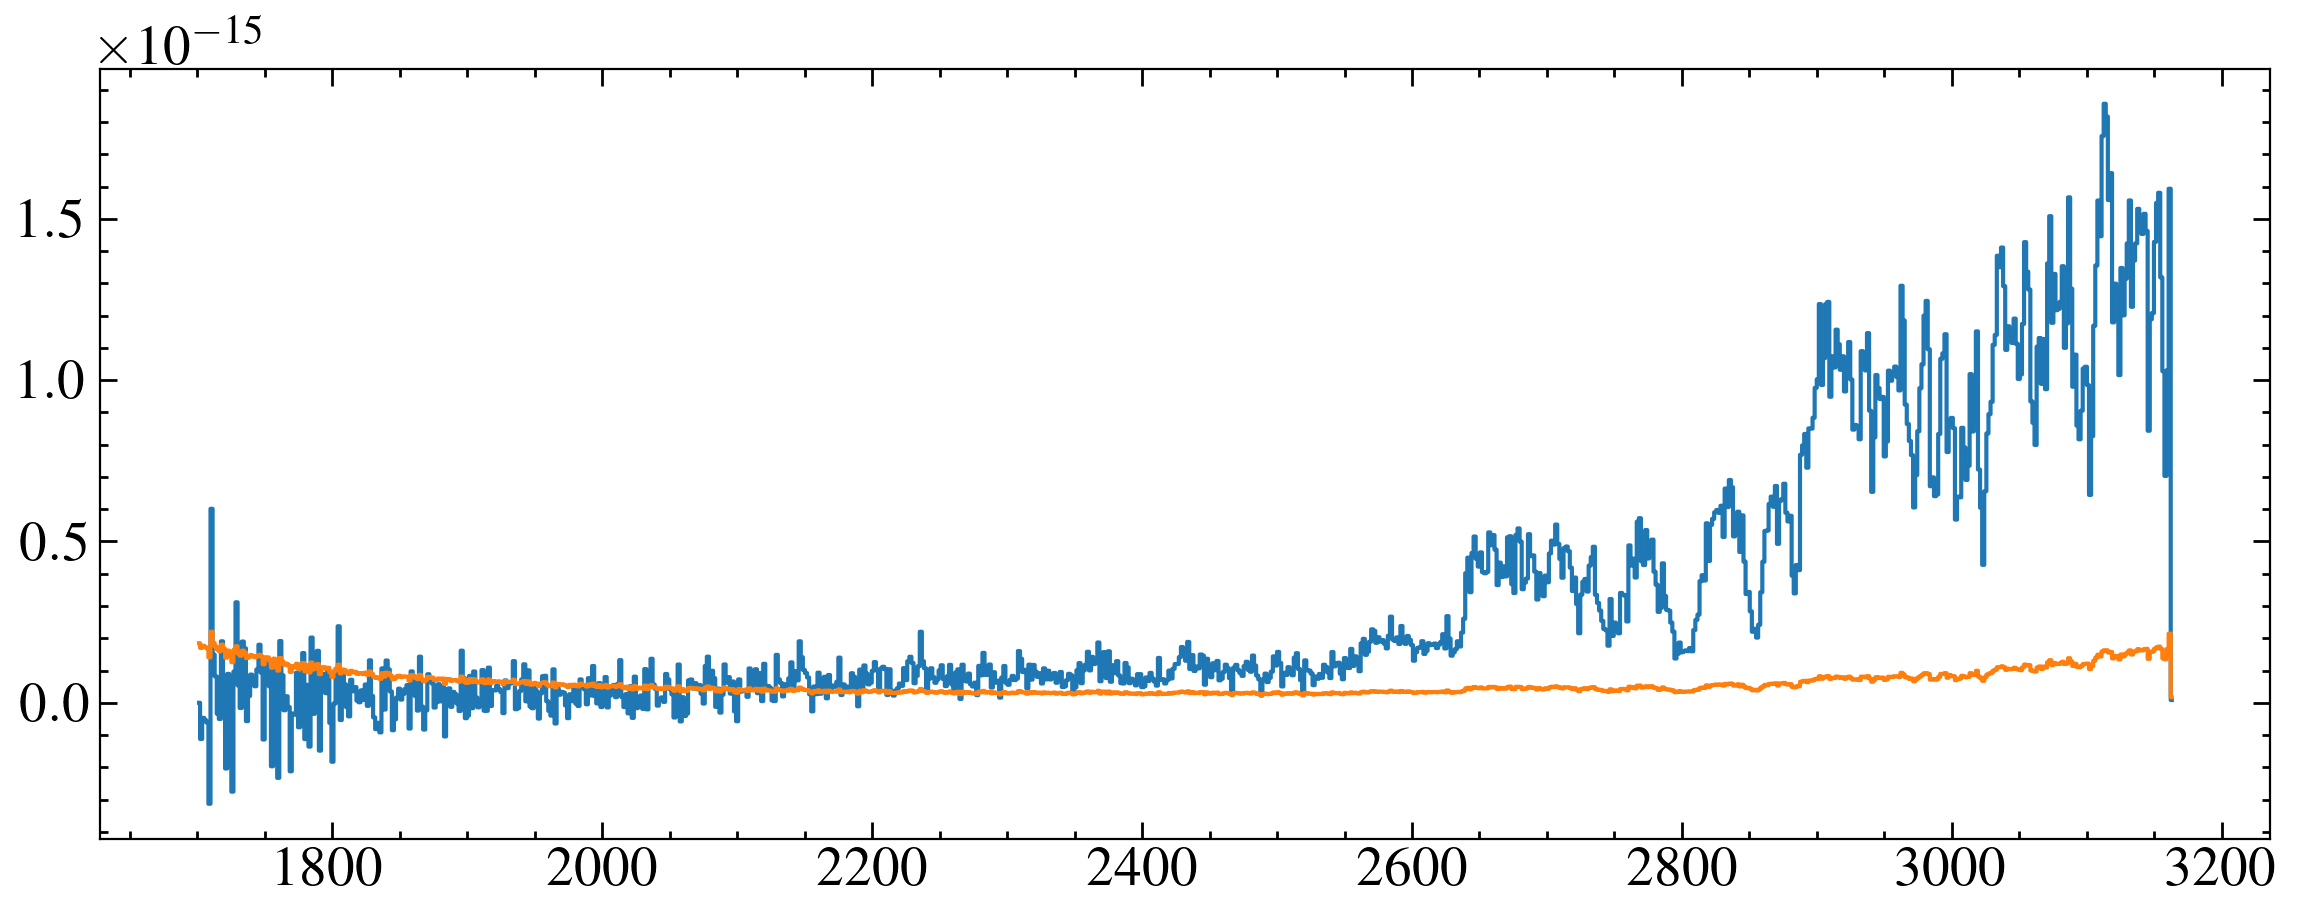

/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37020_x1d.fits
G230L
512.6981


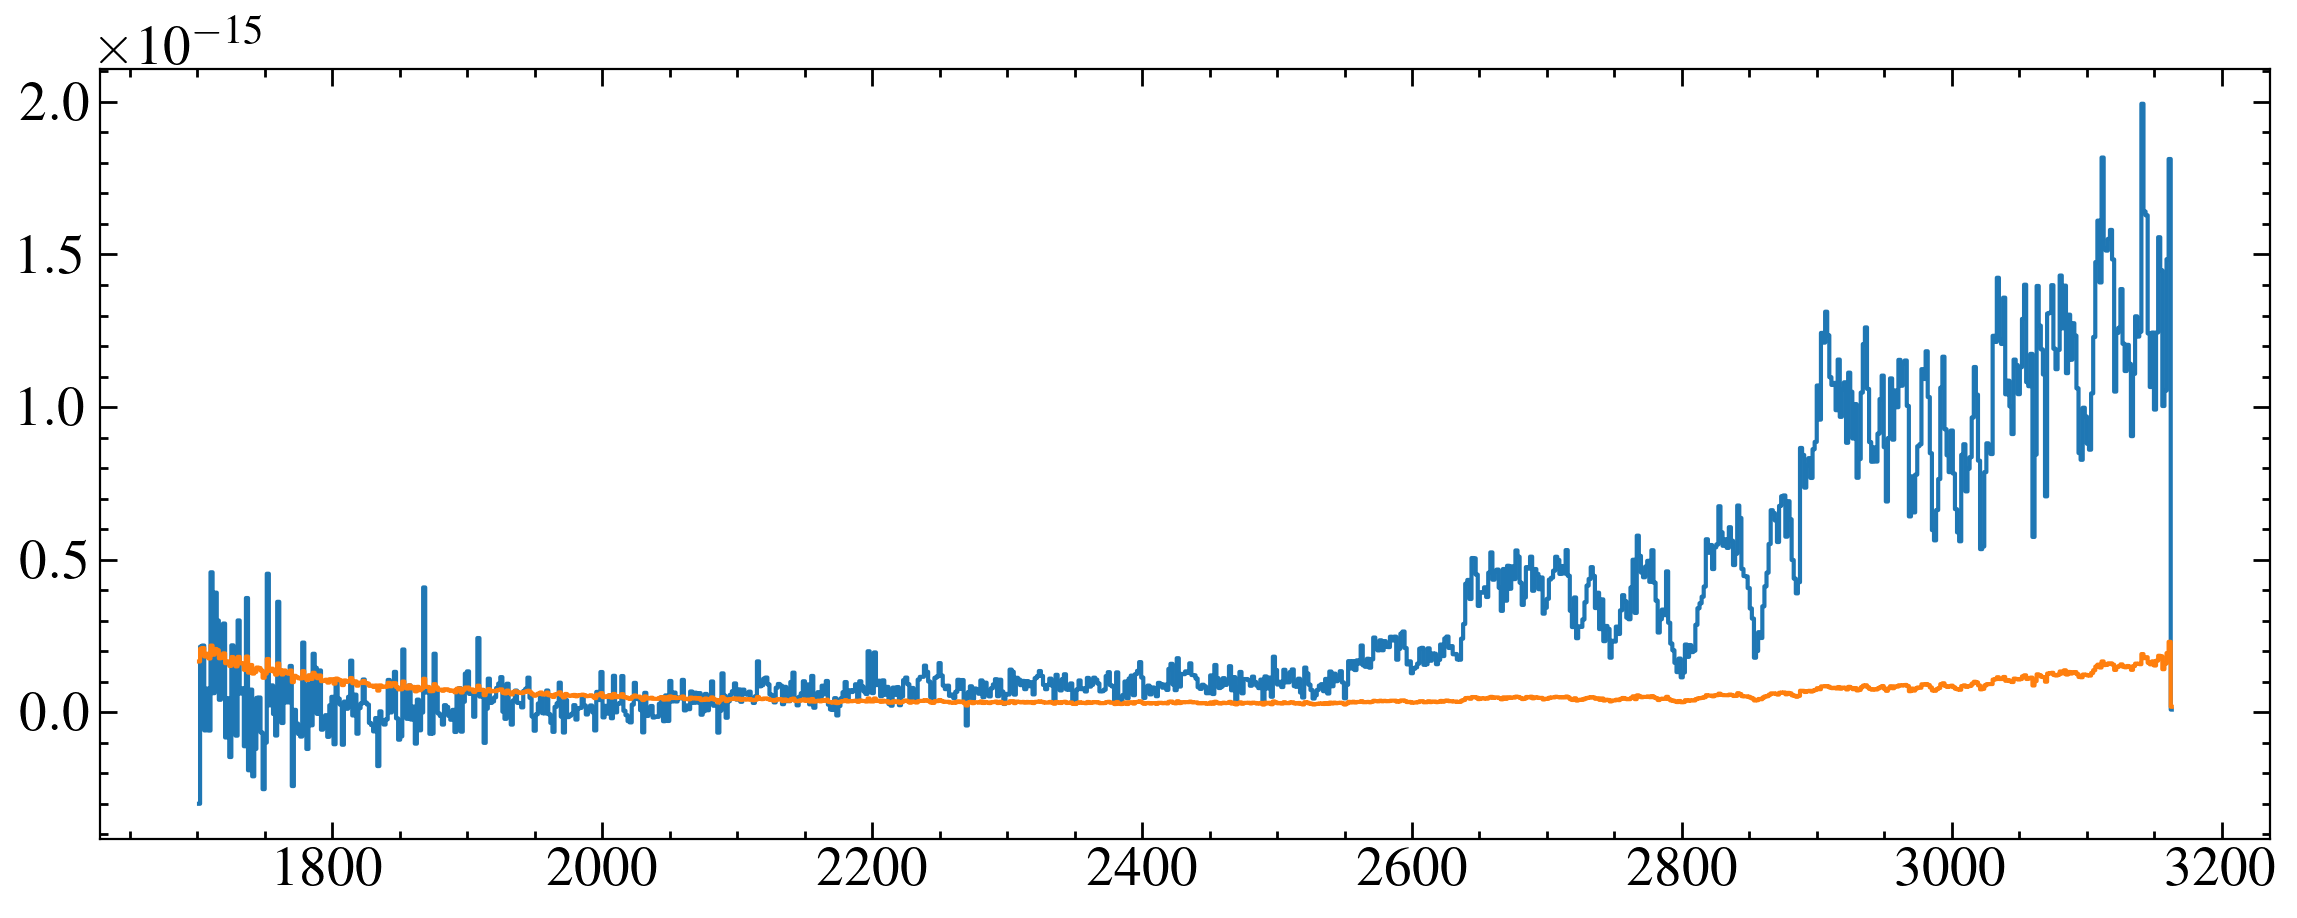

/media/david/2tb_ext_hd/hddata/meats/hst/kepler-51/oeoo37030_sx1.fits
G430L
894.01825


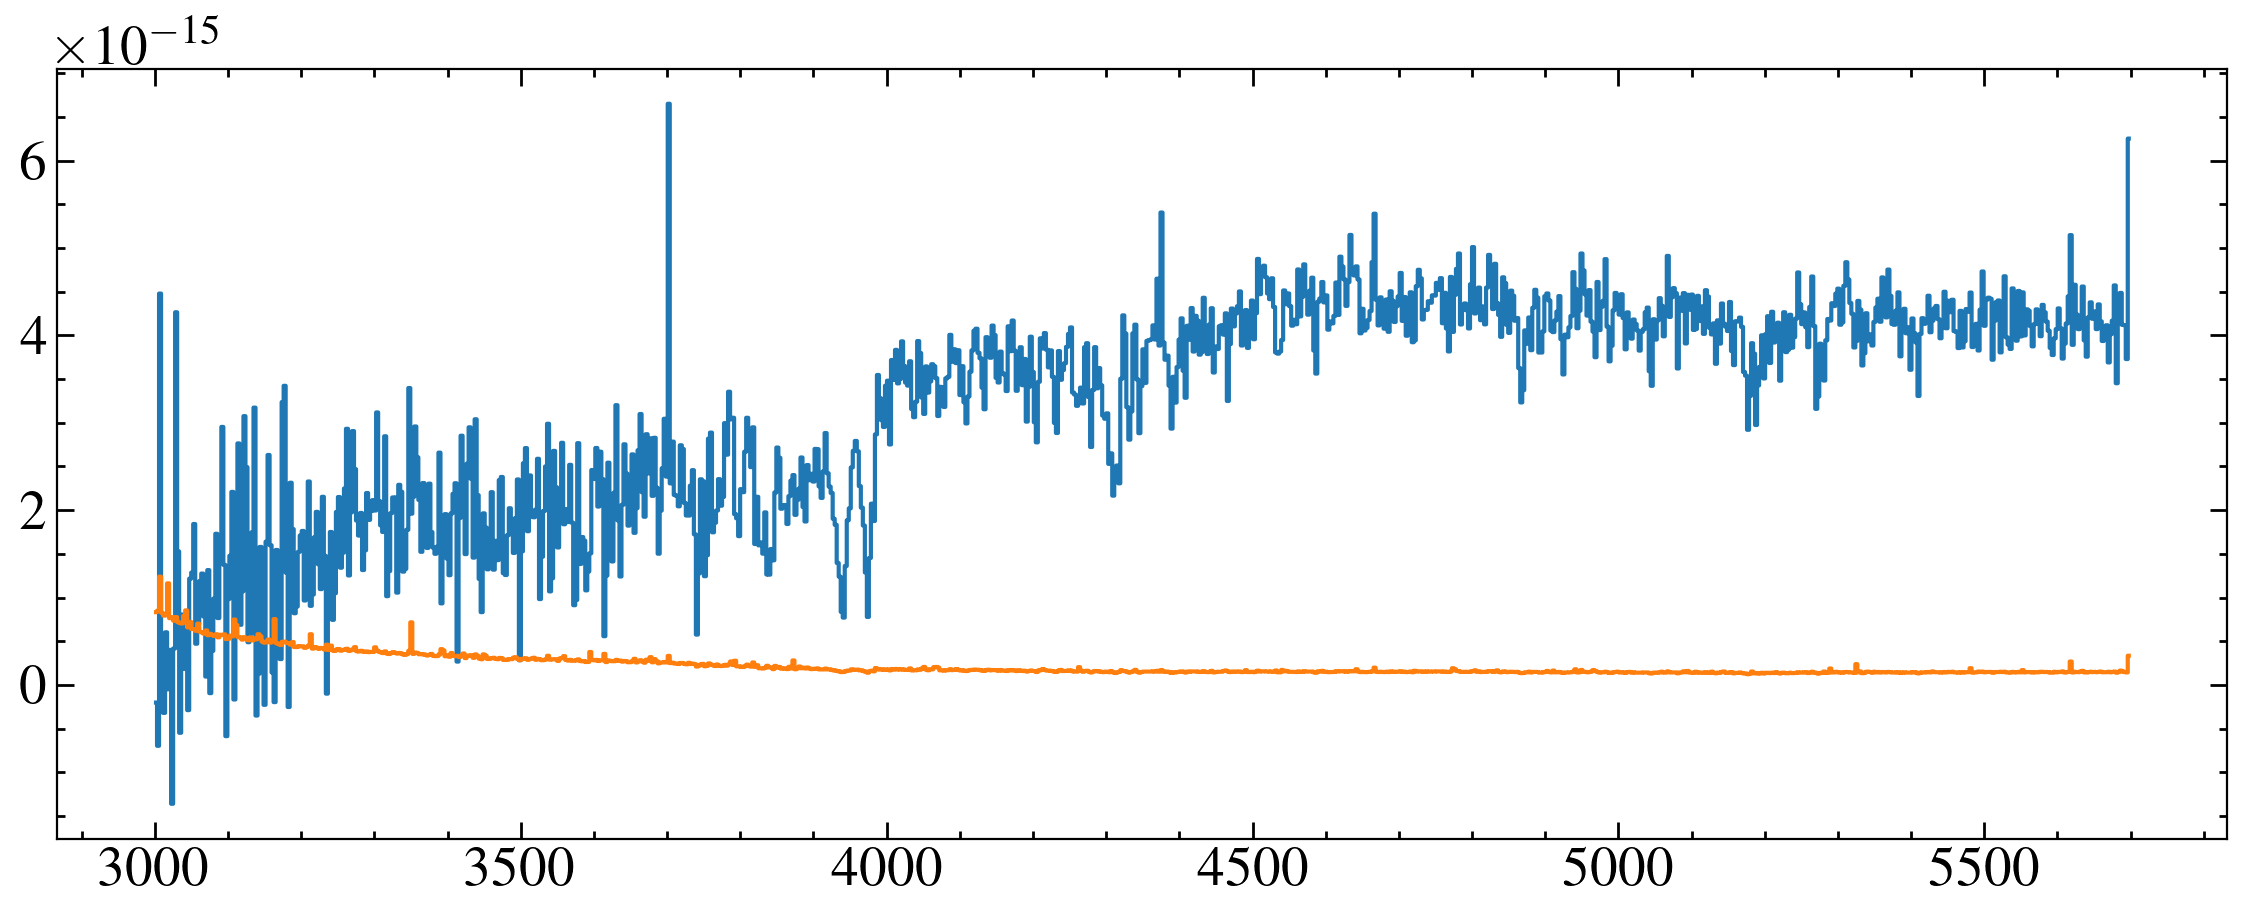

In [3]:
for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    # if x != x1ds:
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating in ['G140M', 'G140L']:
        mask = (w > 1160)
    if grating =='G230L':
        mask = (w > 1700)
    if grating =='G430L':
        mask = (w > 3000)
    
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.show()
    

In [4]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

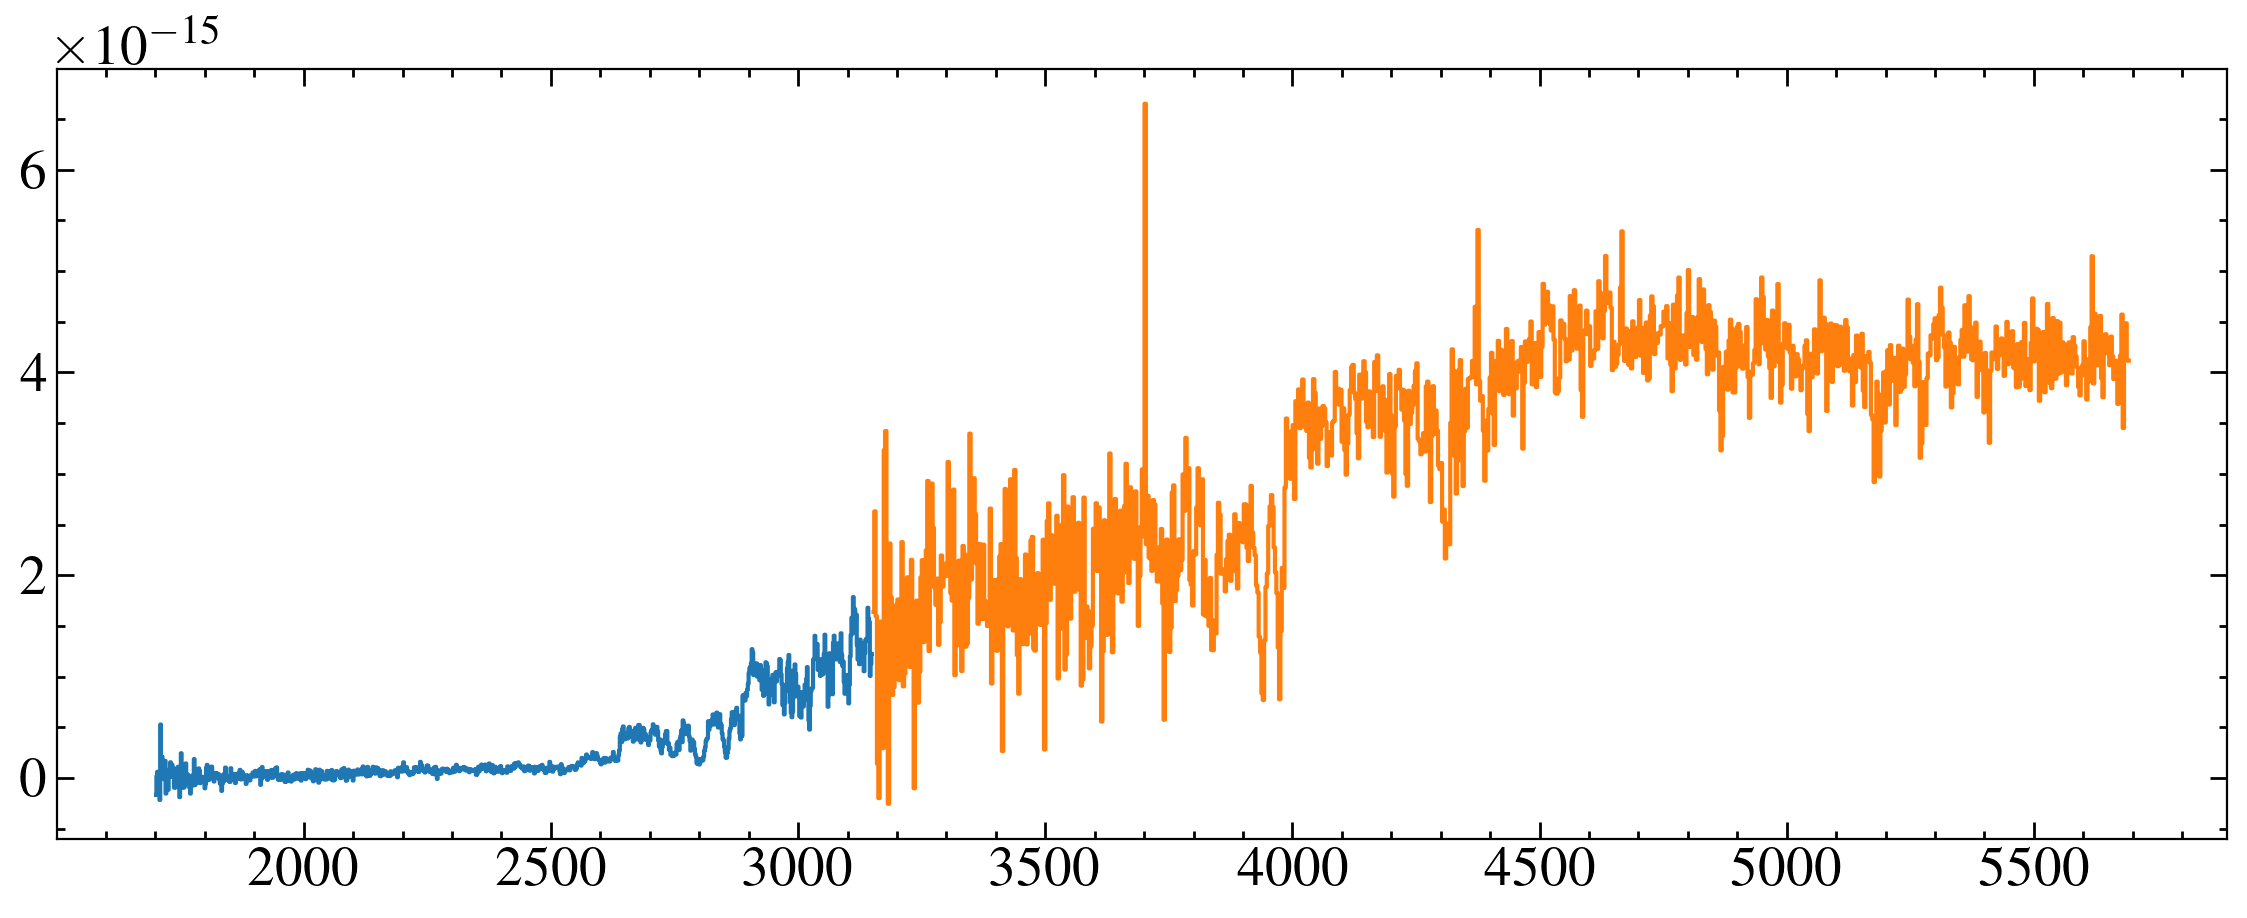

In [5]:
w_nuv = []
f_nuv = []
e_nuv = []

n=0
for x in x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e , dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G230L':
        mask = (w > 1700) & (w < 3150)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_nuv = w
            f_nuv.append(f)
            e_nuv.append(e)
        else:
            f_nuv.append(interp1d(w, f, fill_value='extrapolate')(w_nuv))
            e_nuv.append(interp1d(w, e, fill_value='extrapolate')(w_nuv))            
        n +=1
    elif grating == 'G430L':
        mask = (w > 3150) & (w < 5694)
        w_opt, f_opt, e_opt, dq_opt = w[mask], f[mask], e[mask], dq[mask]

f_nuv, e_nuv = spectra_adder(np.array(f_nuv), np.array(e_nuv), scale_correct=True)

plt.step(w_nuv, f_nuv, where='mid')
# plt.step(w_nuv, e_nuv, where='mid')
plt.step(w_opt, f_opt, where='mid', zorder=-1)

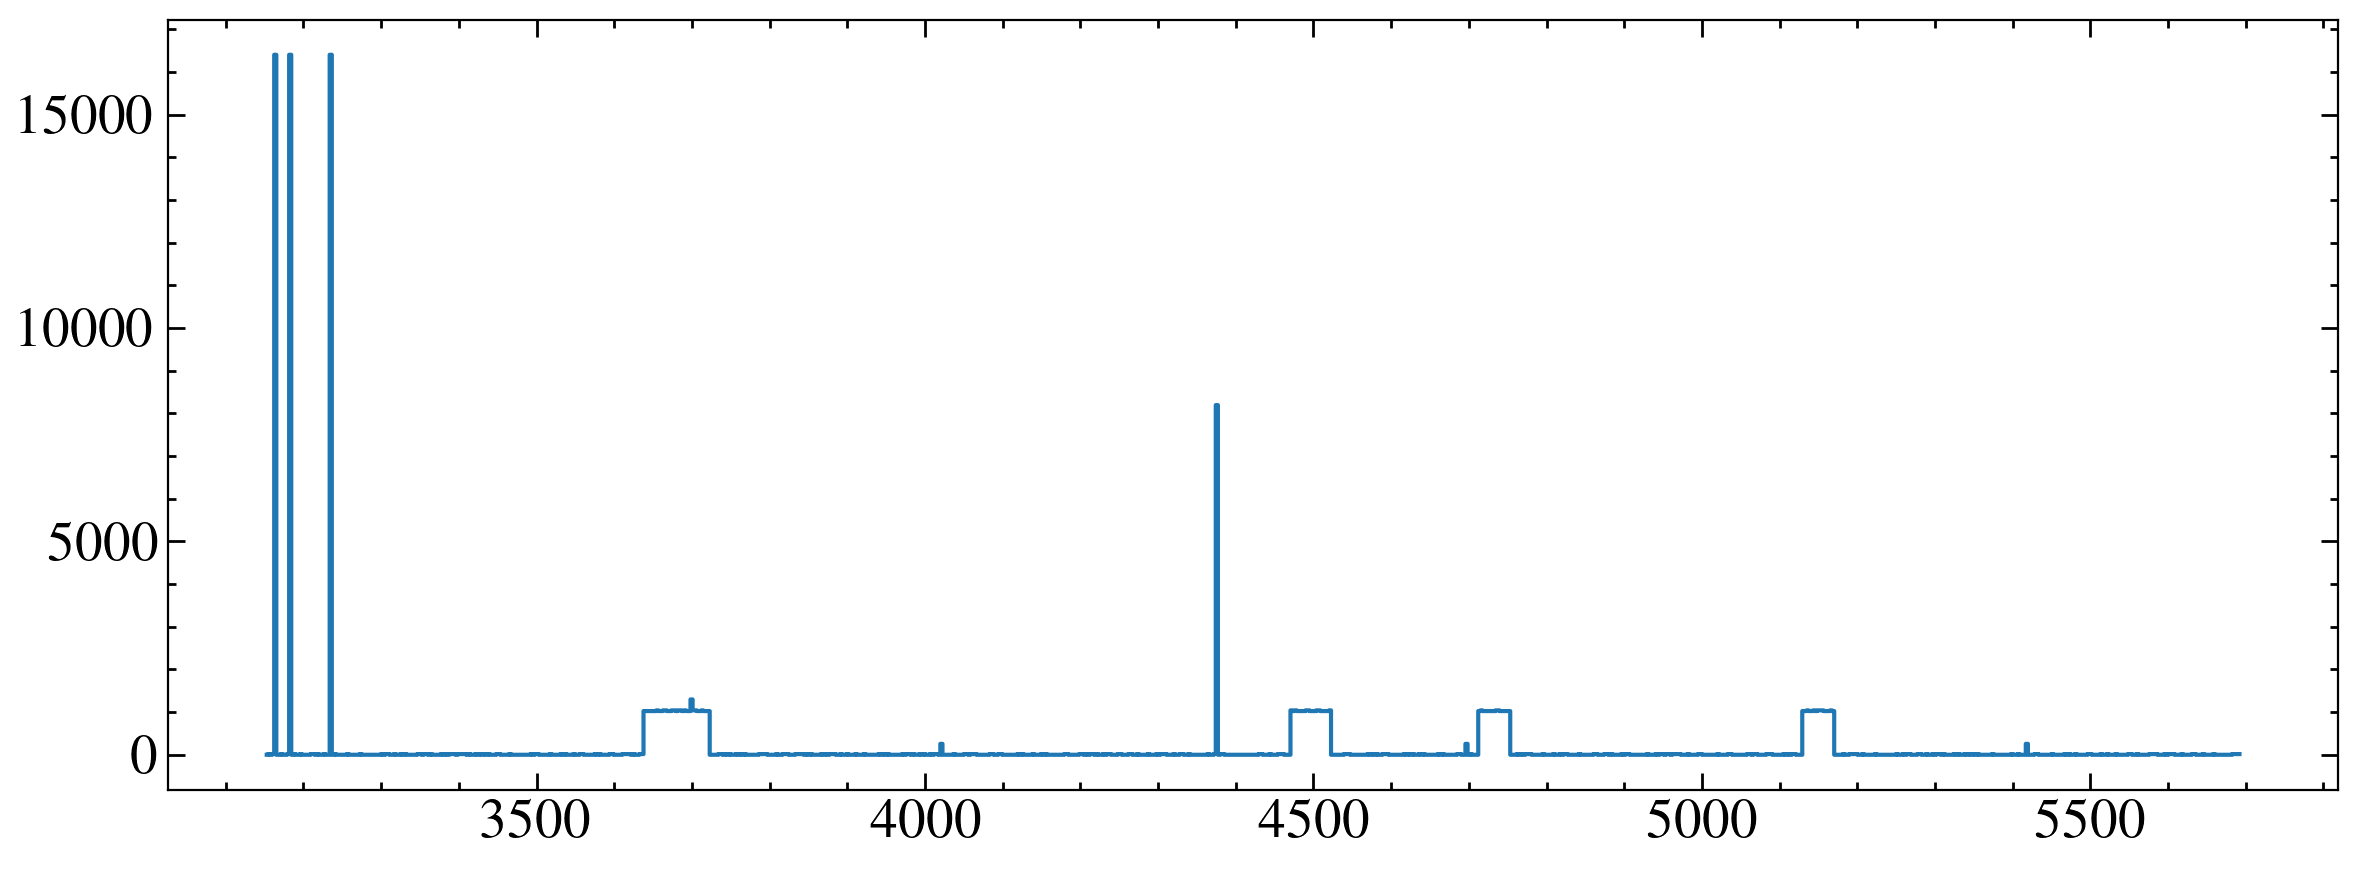

[    0    16   256  1024  1040  1296  8192 16400]


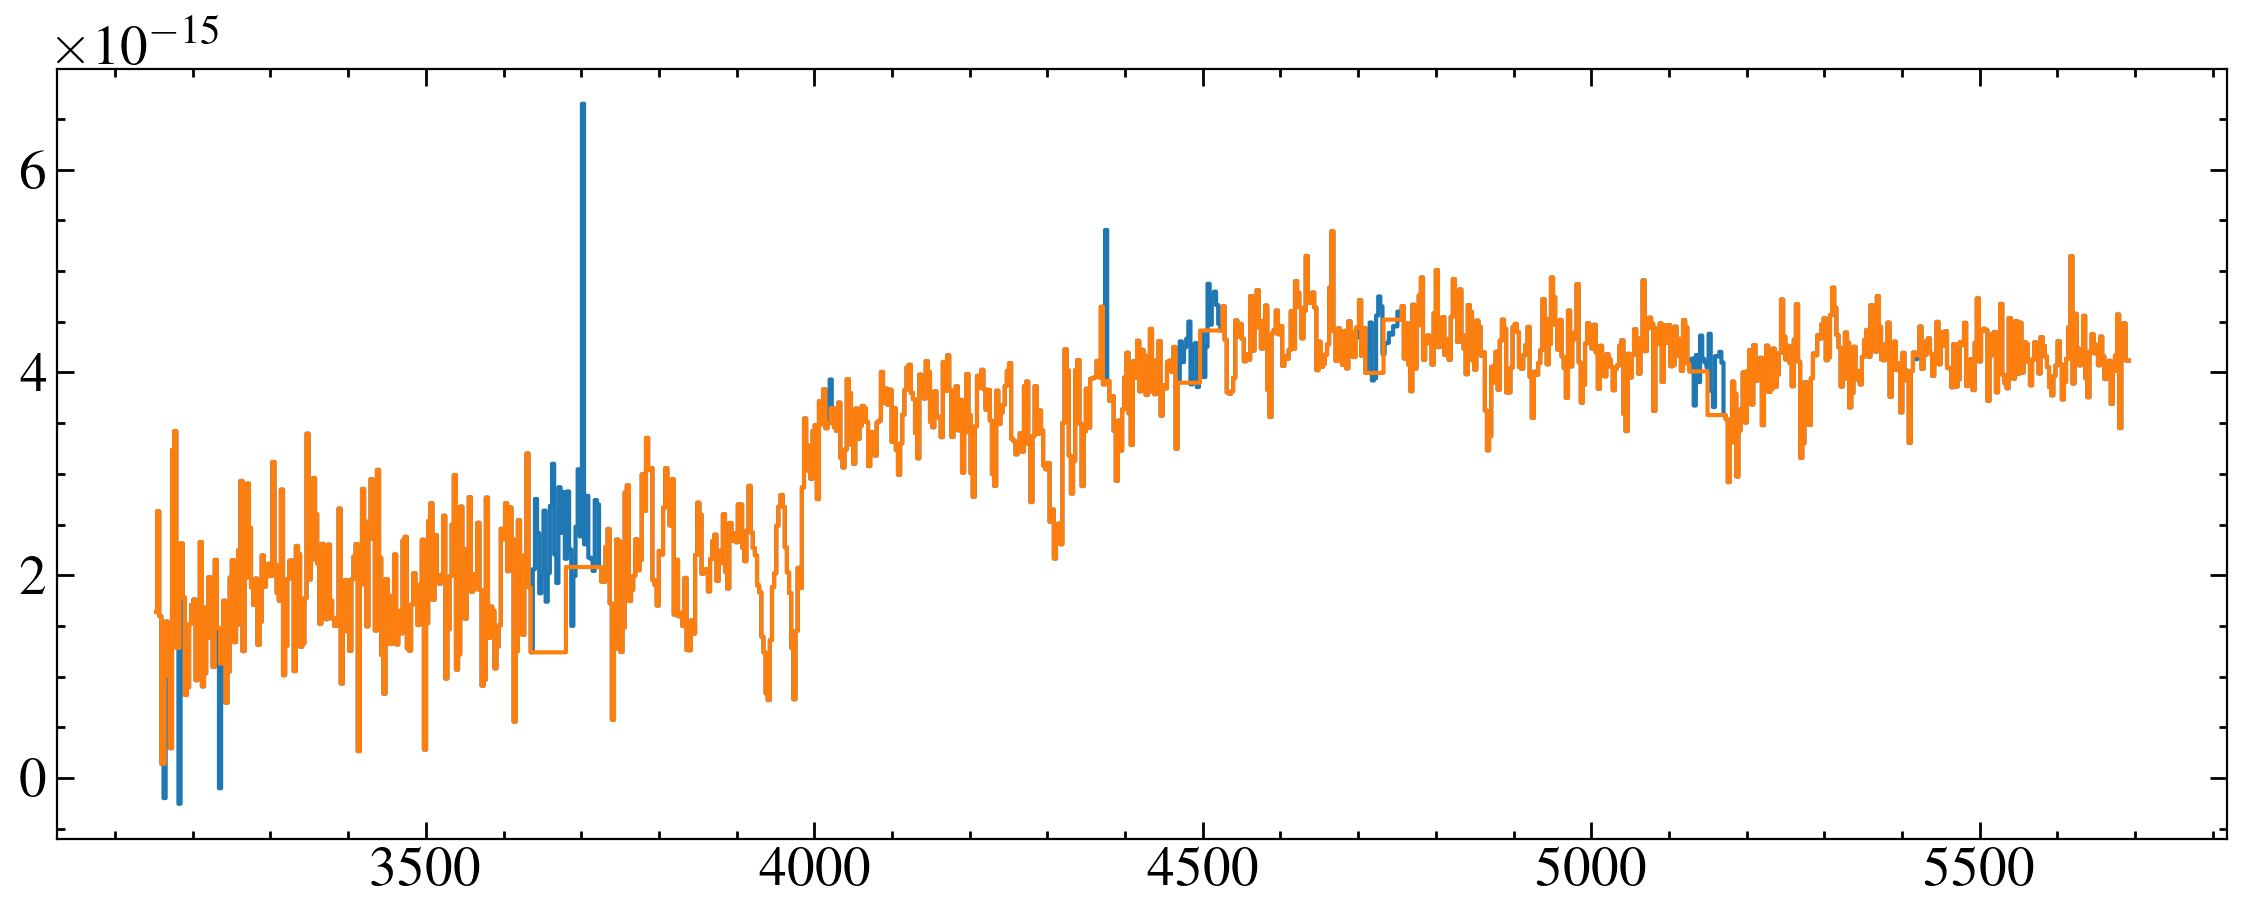

(array([922.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   3.]),
 array([    0.,  1640.,  3280.,  4920.,  6560.,  8200.,  9840., 11480.,
        13120., 14760., 16400.]),
 <BarContainer object of 10 artists>)

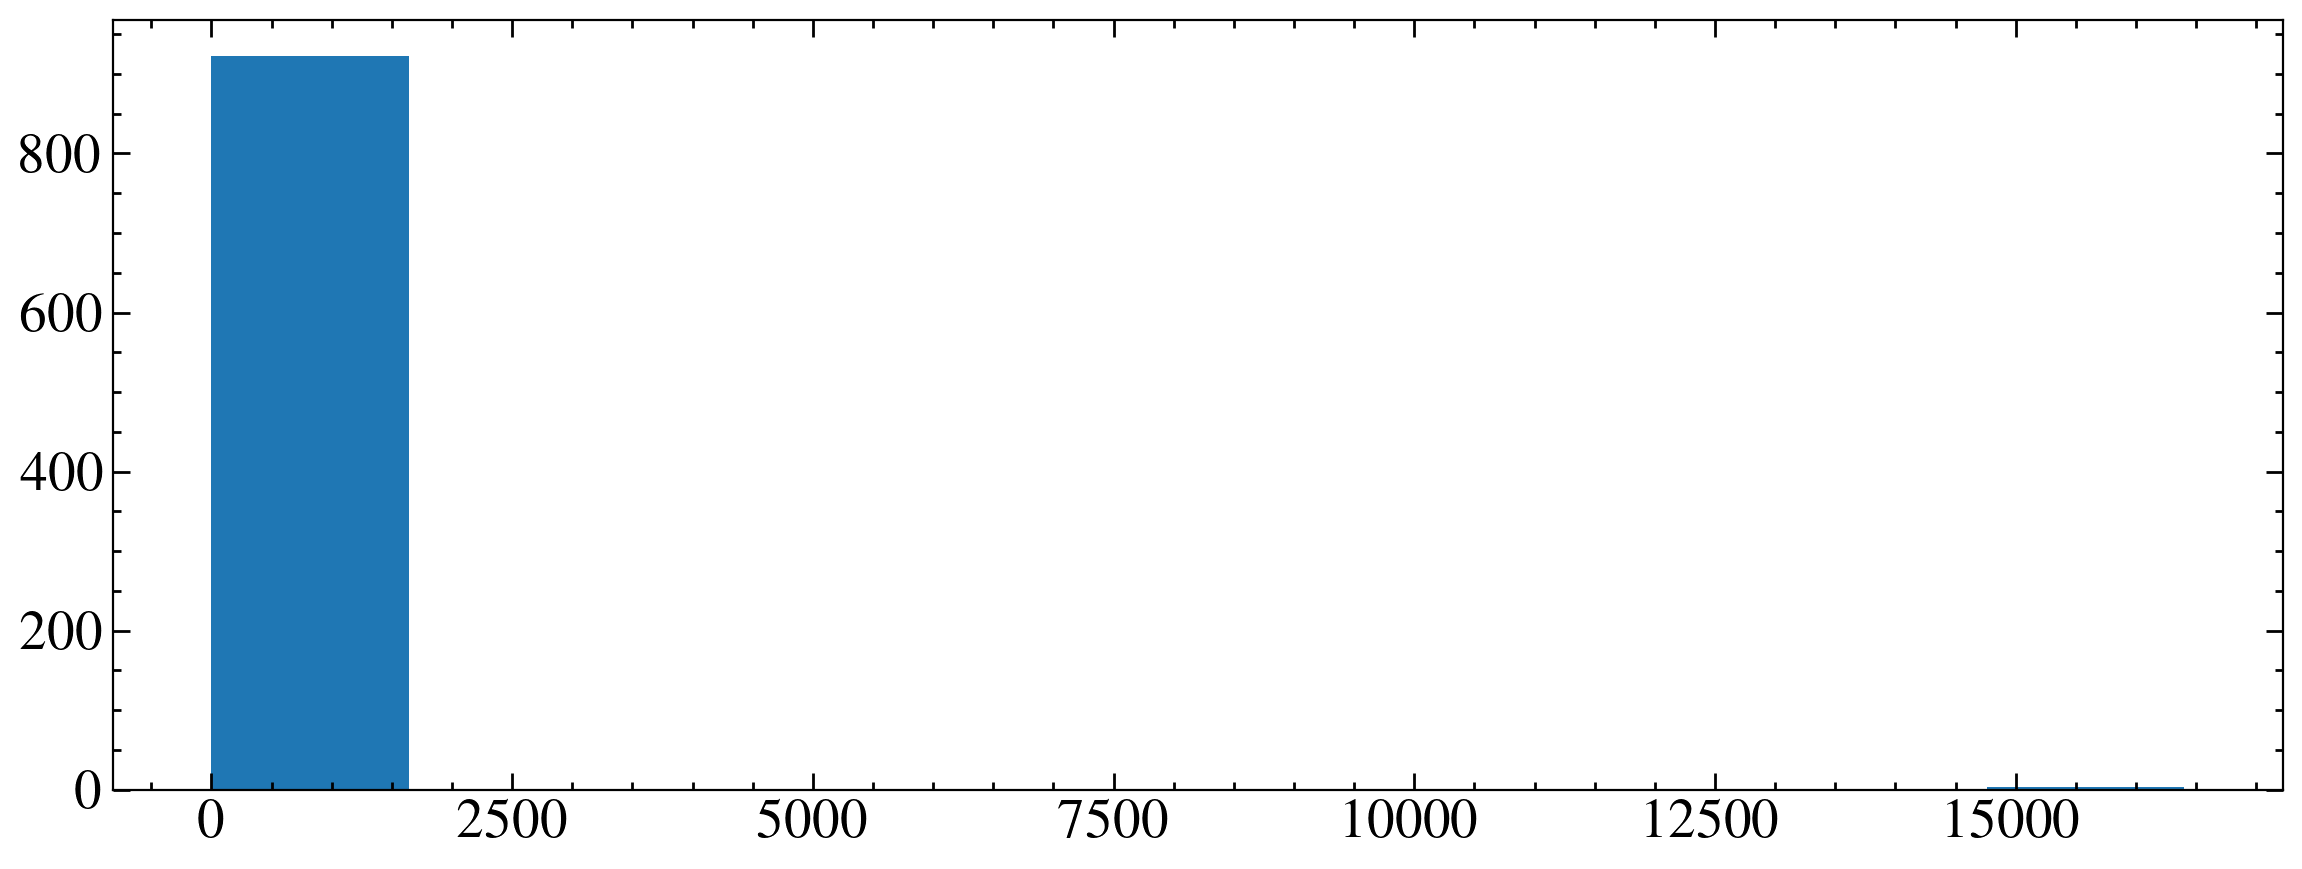

In [6]:
plt.step(w_opt, dq_opt, where='mid', zorder=-1)

plt.show()

plt.step(w_opt, f_opt, where='mid', zorder=-1)
plt.step(w_opt[dq_opt<=16], f_opt[dq_opt<=16], where='mid', zorder=-1)

print(np.unique(dq_opt))

plt.show()
plt.hist(dq_opt)

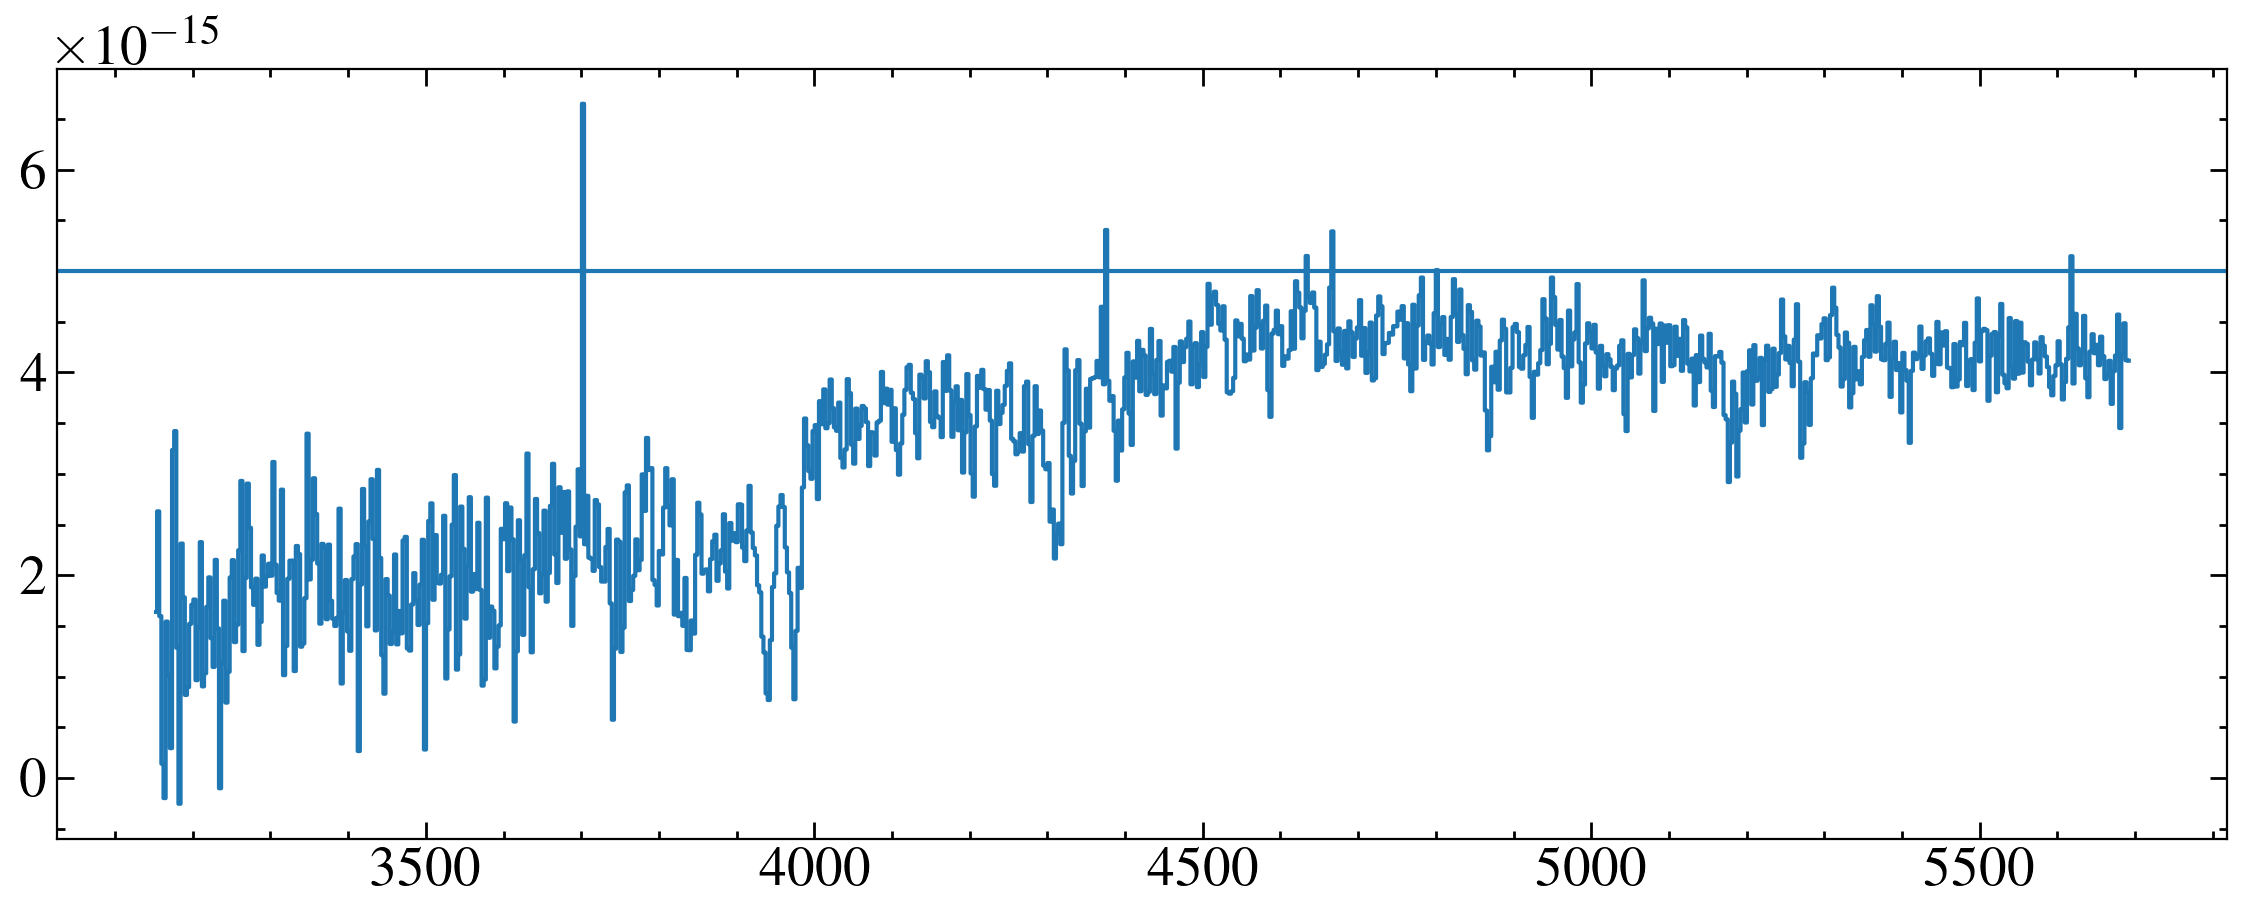

In [7]:
plt.step(w_opt, f_opt, where='mid', zorder=-1)
plt.axhline(5e-15)

Looked at Keck data, spikes aren't real

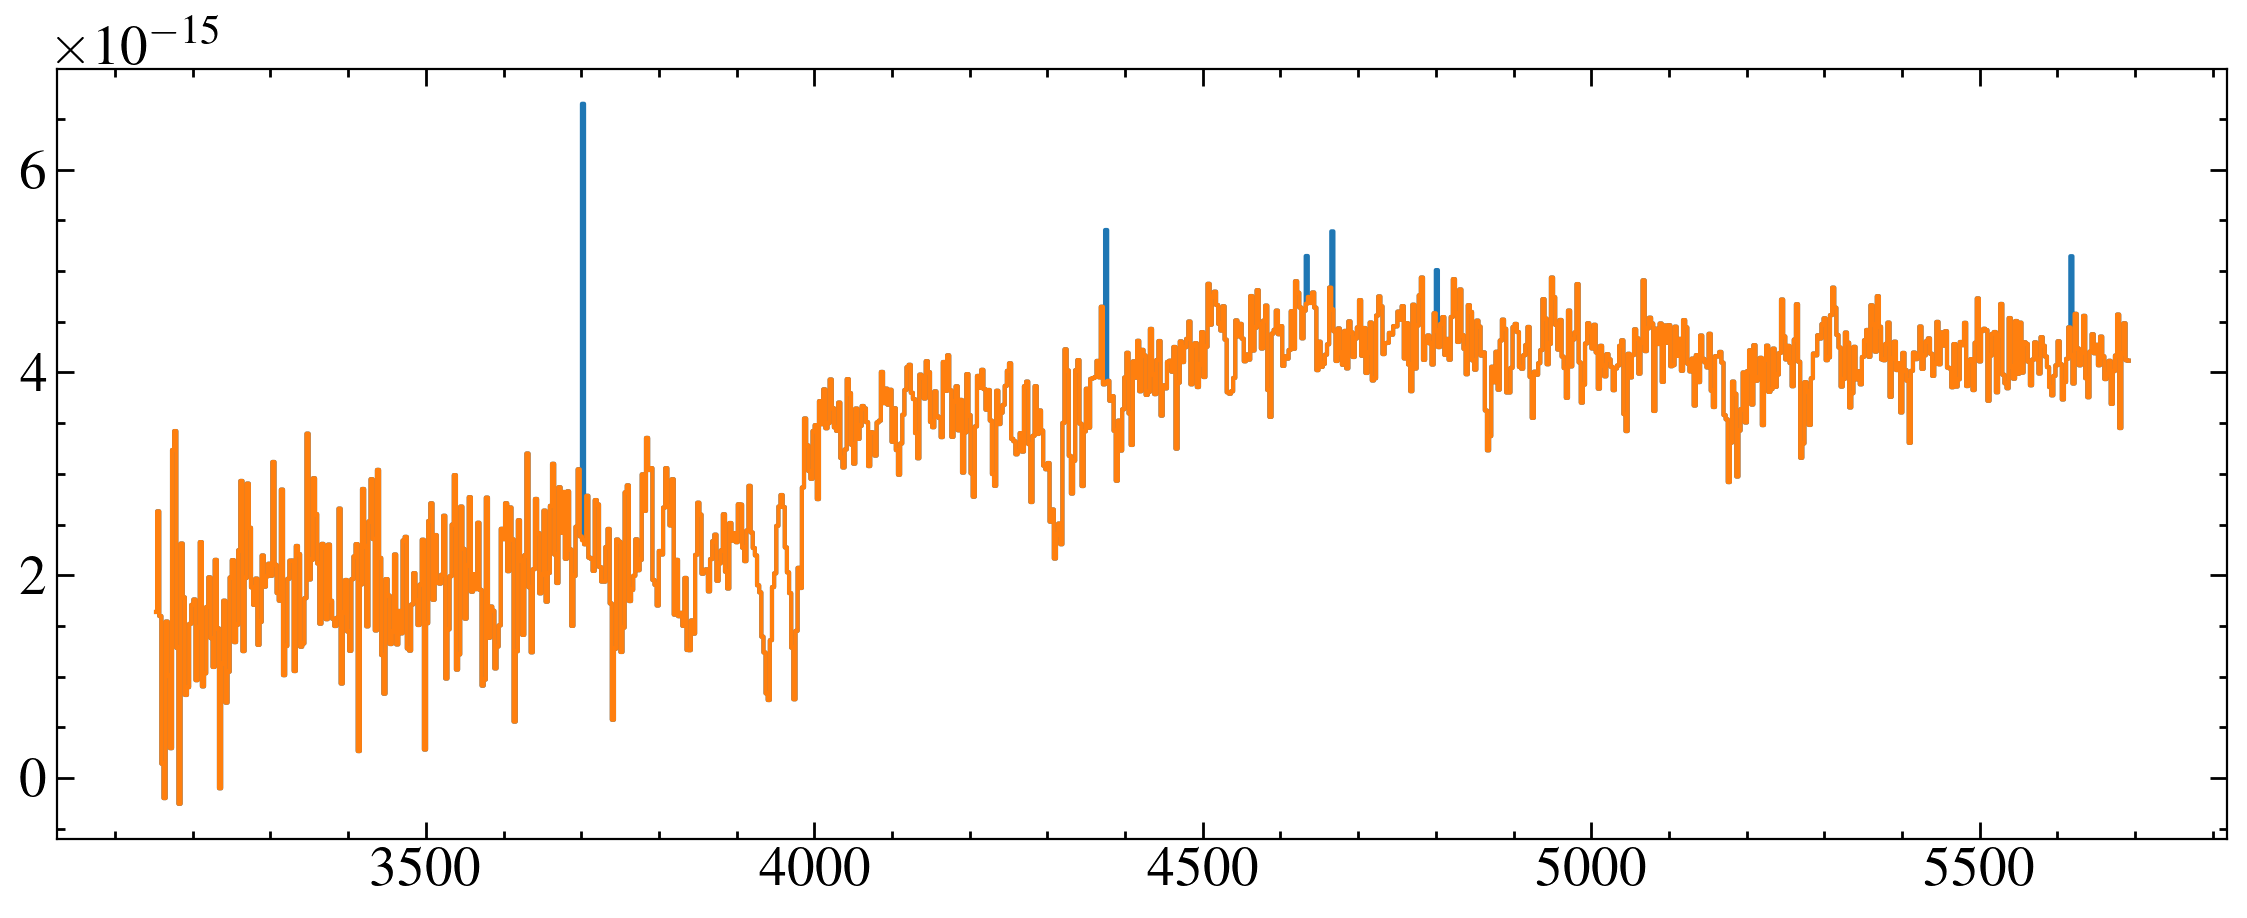

In [8]:
fopti = np.copy(f_opt)
for i in range(len(f_opt)-10):
    if f_opt[i] > 5e-15:
        fopti[i] = np.mean([f_opt[i-1],f_opt[i+1]])  
    
plt.step(w_opt, f_opt, where='mid')
plt.step(w_opt, fopti, where='mid')

In [9]:
import stistools
os.environ['oref'] = path

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


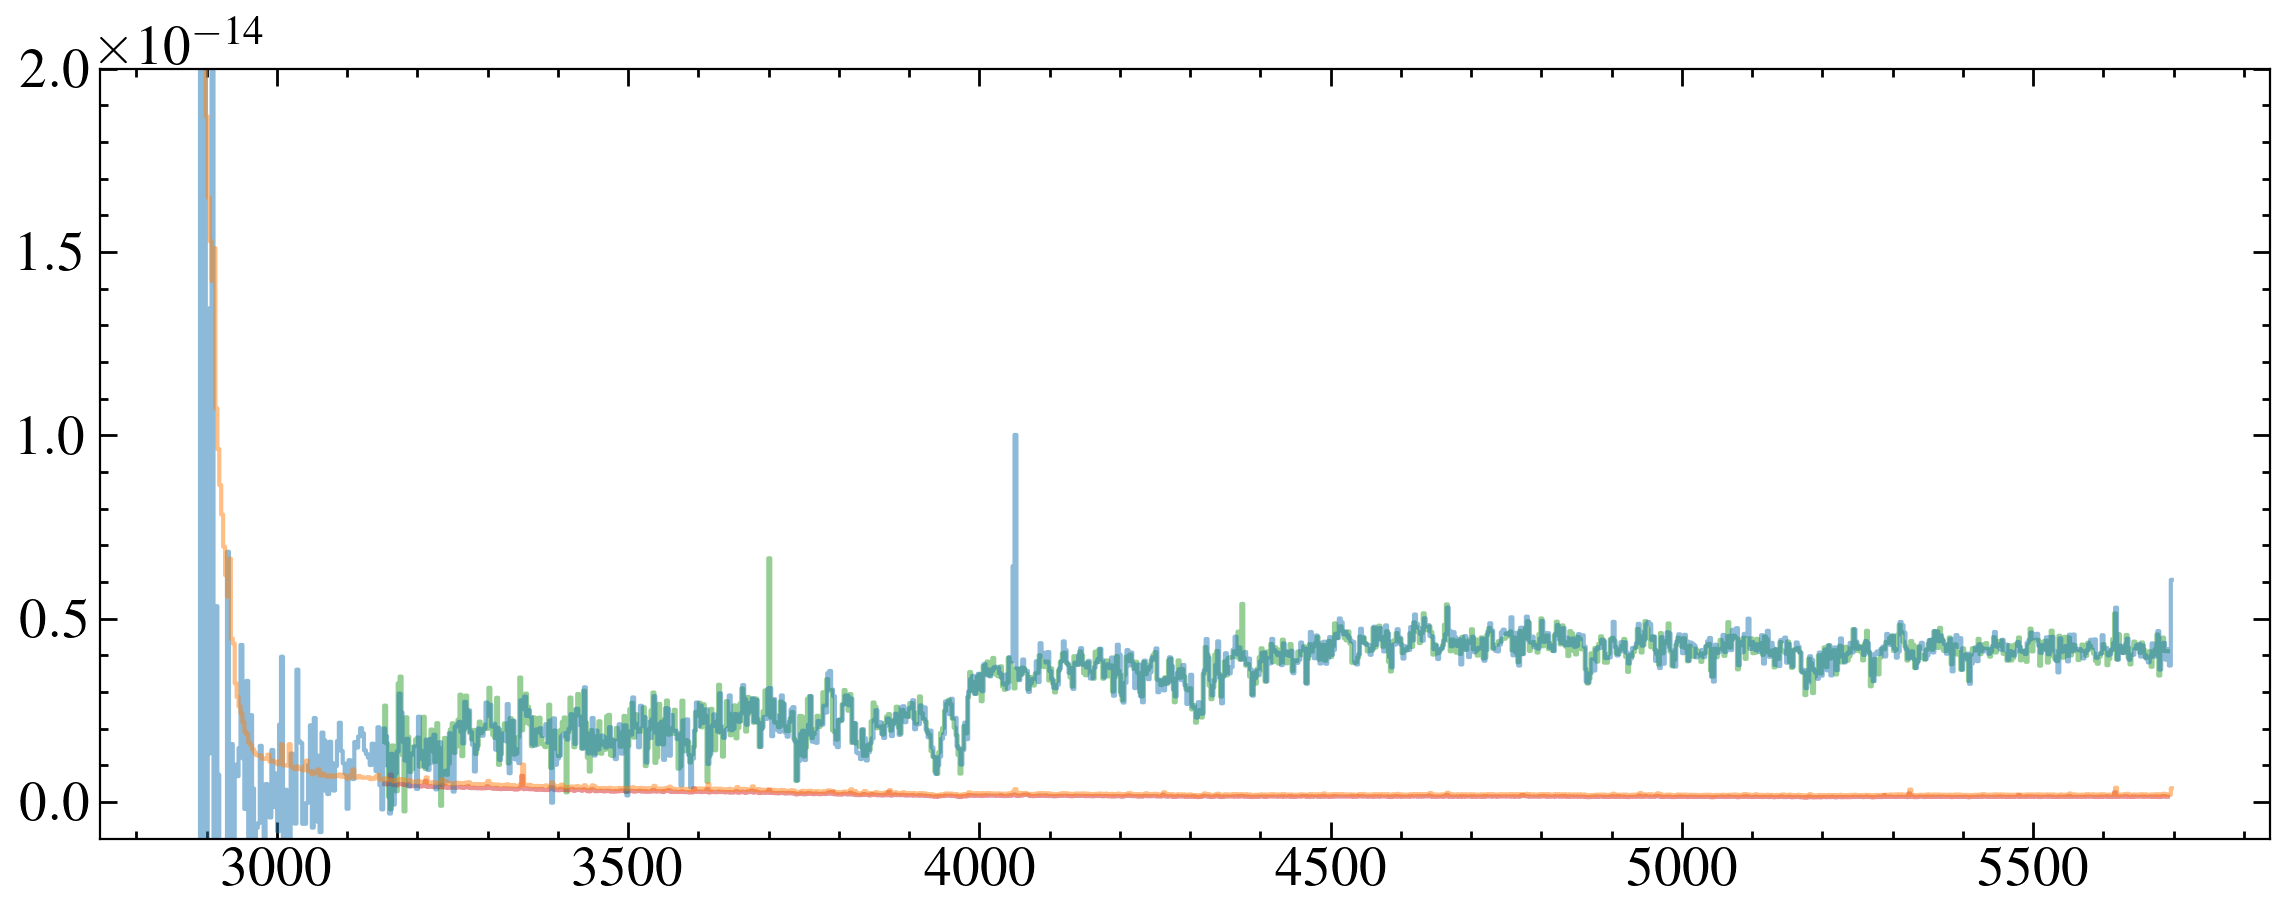

In [10]:
roots = ['oeoo37030']

for i, root in  enumerate(roots):
    root = root.lower()
    flt = '{}/{}_flt.fits'.format(path, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
#     tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/kepler-51/{}_new_sx1.fits'.format(rootname)
    if os.path.exists(outname):
        os.remove(outname)
#     a2center = get_a2center(xs[i],ys[i], tracegrid)
#     print(root)
#     print(a2center)
    # a2center = 375
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/kepler-51/{}_new.trl'.format(rootname), extrsize=5, bk1offst=30,bk2offst=30, bk1size=30,bk2size=30  )
    
    data = fits.getdata(outname, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1150 
    w, f, e = w[mask], f[mask], e[mask]
    
    plt.step(w, f, where='mid', alpha=0.5)
    plt.step(w, e, where='mid', alpha=0.5)
    
# plt.xlim(1150, 1250)
plt.ylim(-0.1e-14, 2e-14)
# plt.axhline(0, ls='--', c='0.5')
       
plt.step(w_opt, f_opt, zorder=-1, alpha=0.5)
plt.step(w_opt, e_opt, zorder=-1, alpha=0.5)
    

So rextracting introduces that big spike? I don't think the spikes are important, can just live with them probably.

In [11]:
import prepare_stis

/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


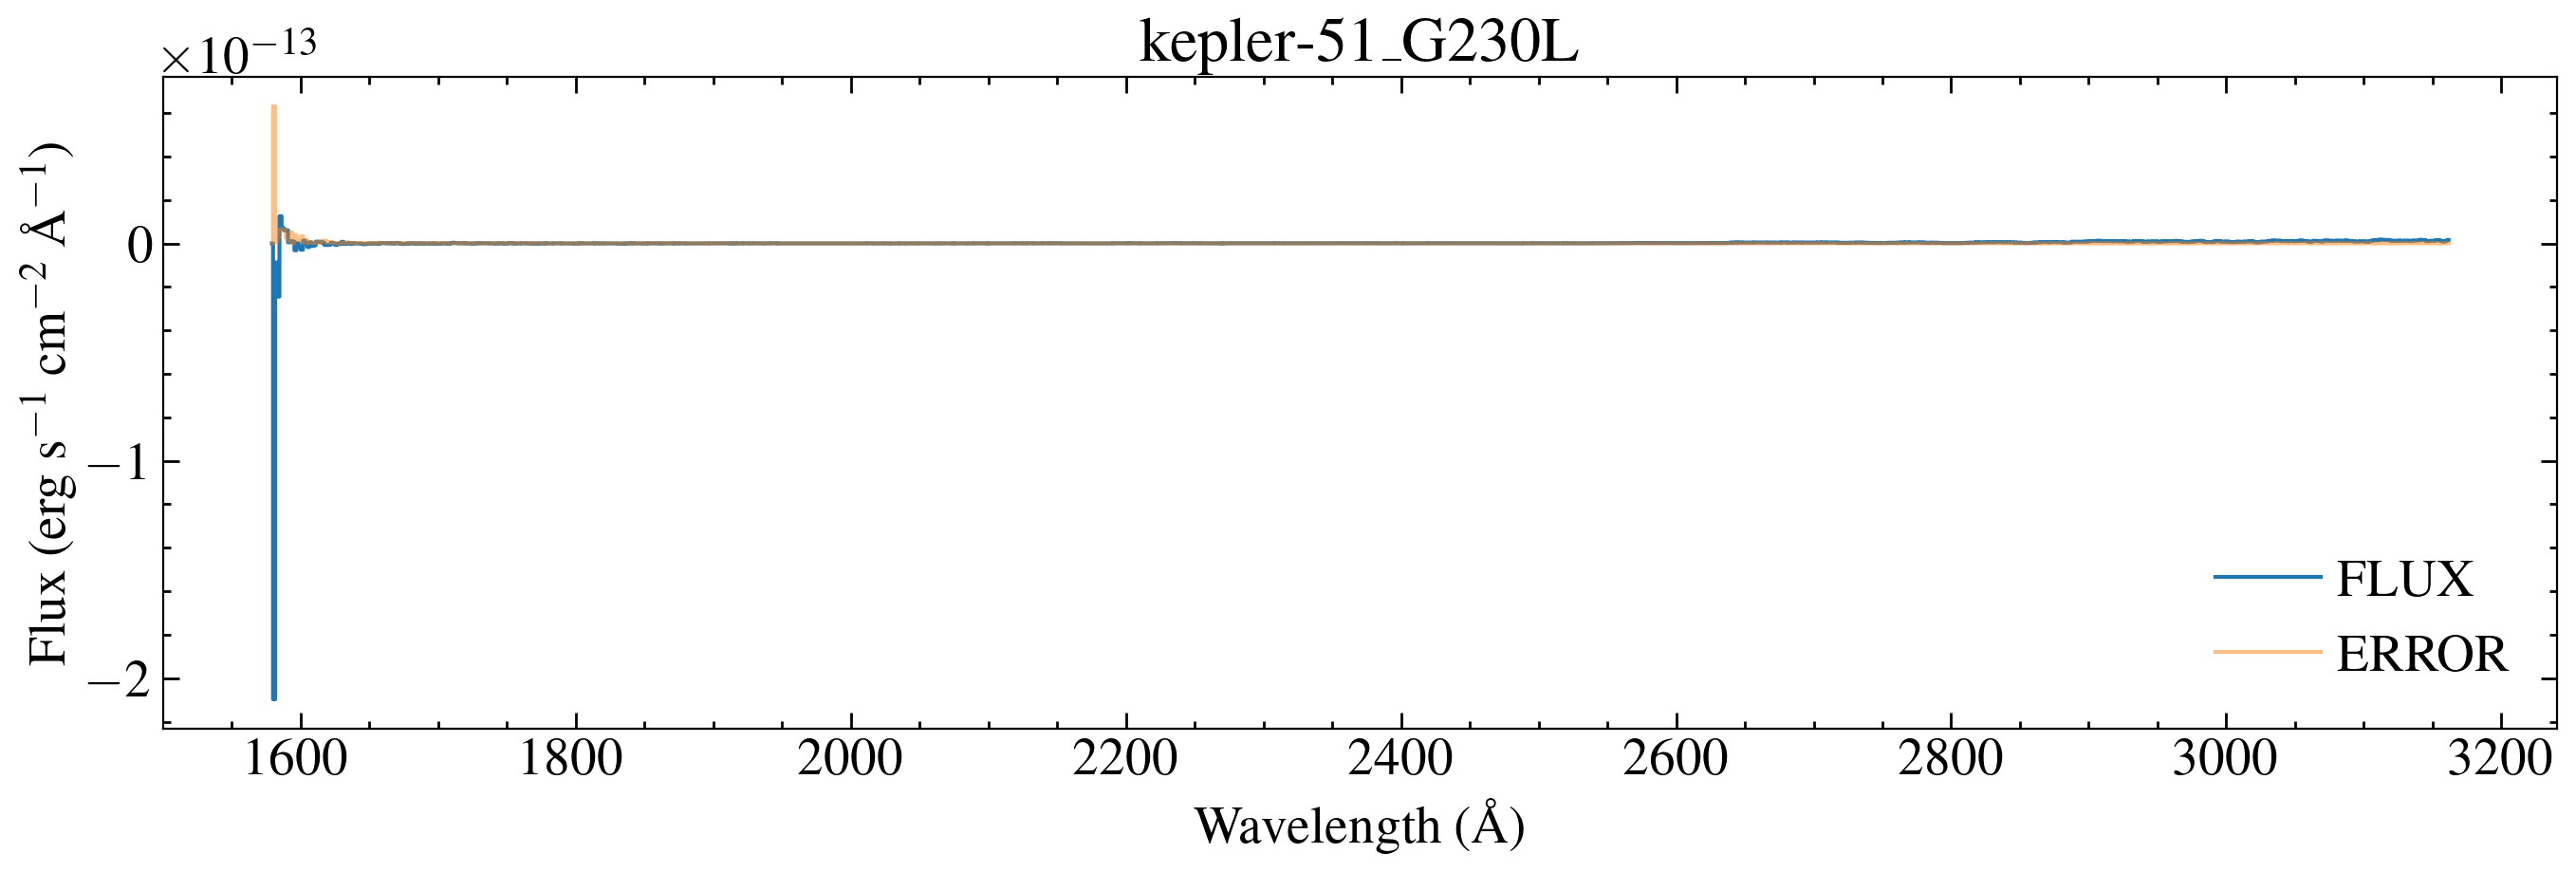

Spectrum saved as hlsp_muscles_hst_stis_kepler-51_g230l_v1_component-spec.fits


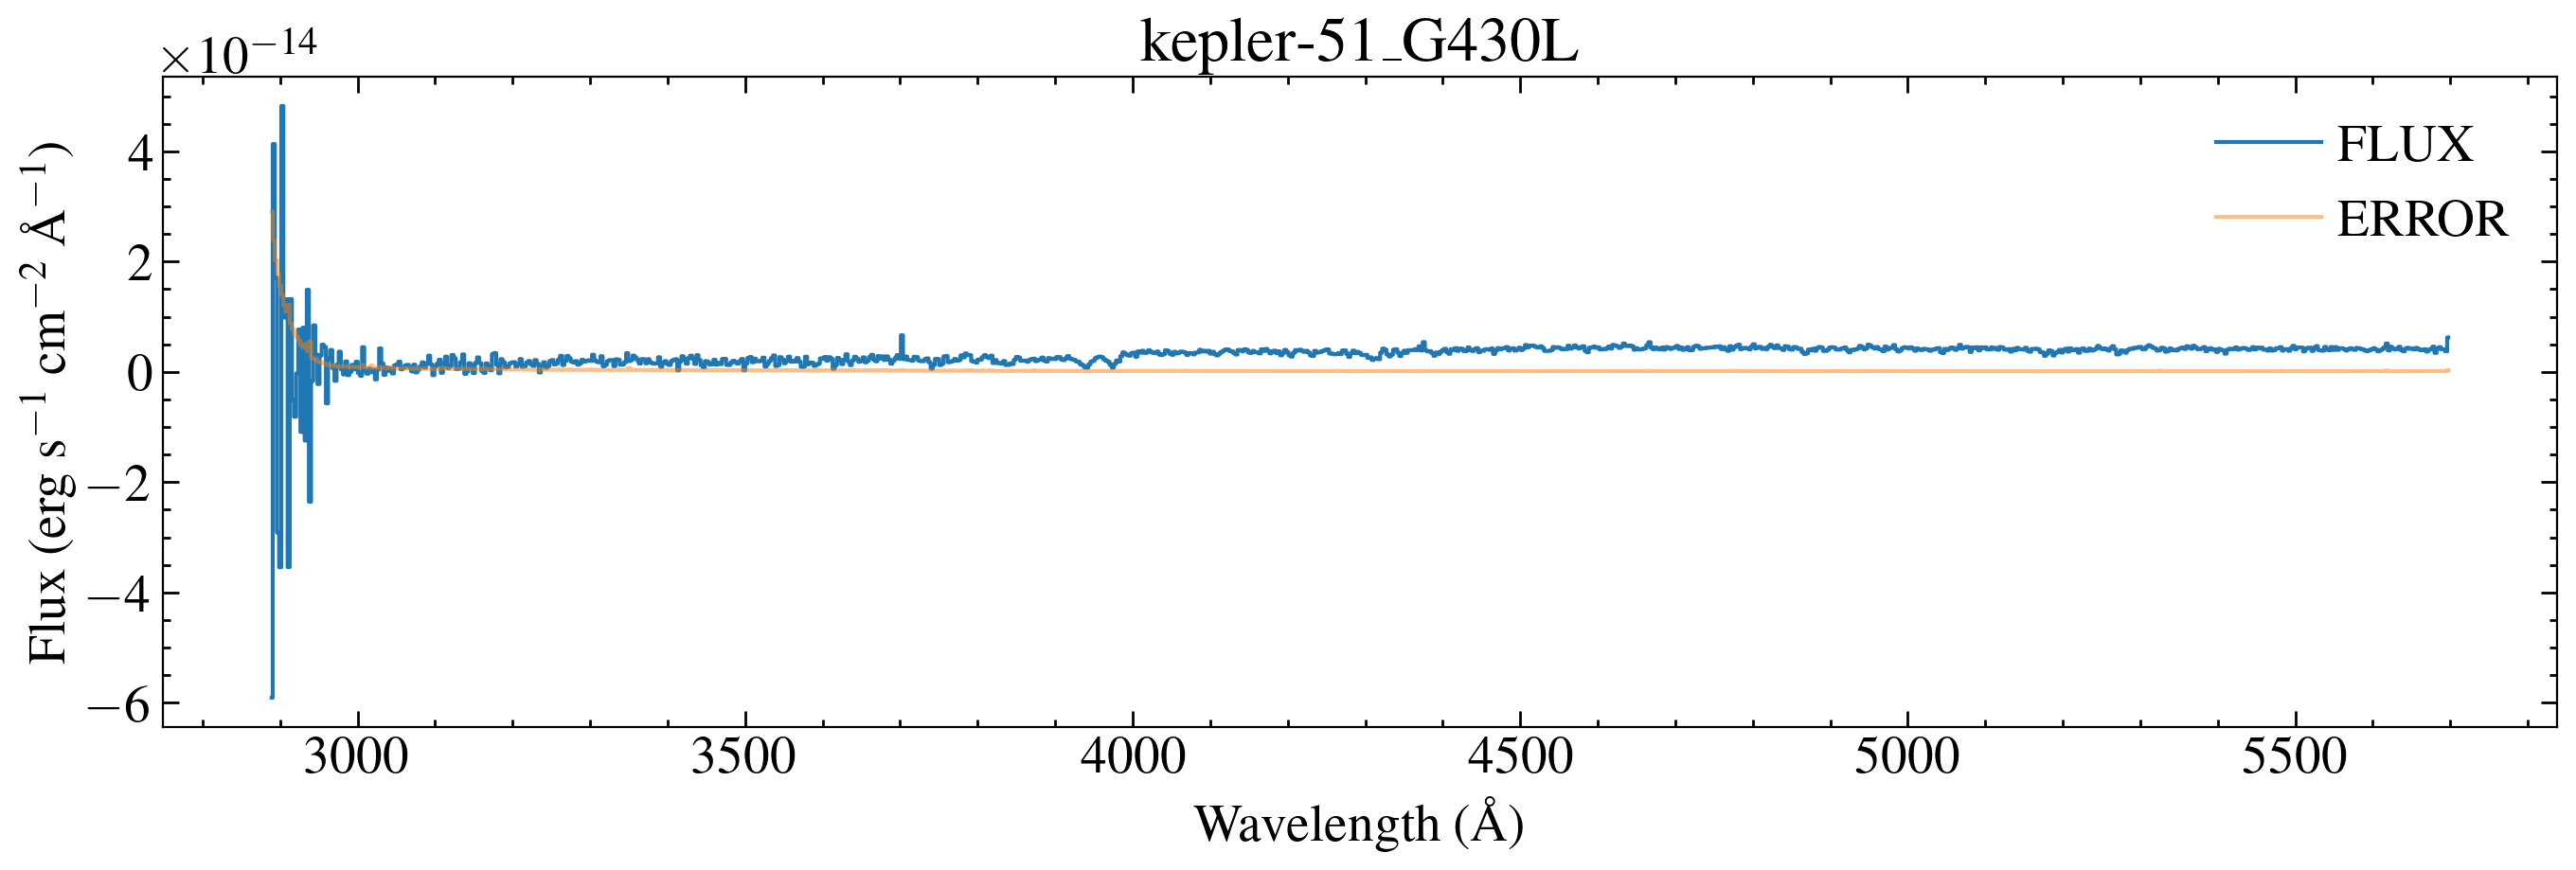

Spectrum saved as hlsp_muscles_hst_stis_kepler-51_g430l_v1_component-spec.fits


In [12]:
savepath = 'draft_hlsp/kepler-51/'
hlsp = 'meats_hlsp_info.csv'
version = 1
star = 'kepler-51'
x1dpath = path
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath=savepath, plot=True, save_ecsv=False, save_fits=True, star=star, nclip=5)

In [13]:
import prepare_phoenix_svo as pp

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)

mass = 0.985
teff = 5670
teff_e = 60
radius = 0.881
distance = 801.73
save_path = 'models/'
star = 'kepler-51'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
# print(np.log10(g.value))
g = 4.541
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc, 'Teff_e':teff_e}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=False, make_error=True)
normfac = ((radius*R)/(distance*u.pc.to(u.m)))**2
pdata = Table.read('models/kepler-51_phoenix_interpolated.ecsv')
pw, pf, pe =  pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR'] 

In [14]:
# plt.plot(pw, pf*normfac)
# plt.yscale('log')
# plt.xscale('log')

Maybe need to deredden? Yes, Ebv = 0.125

[1.29690412]


(1600.0, 7000.0)

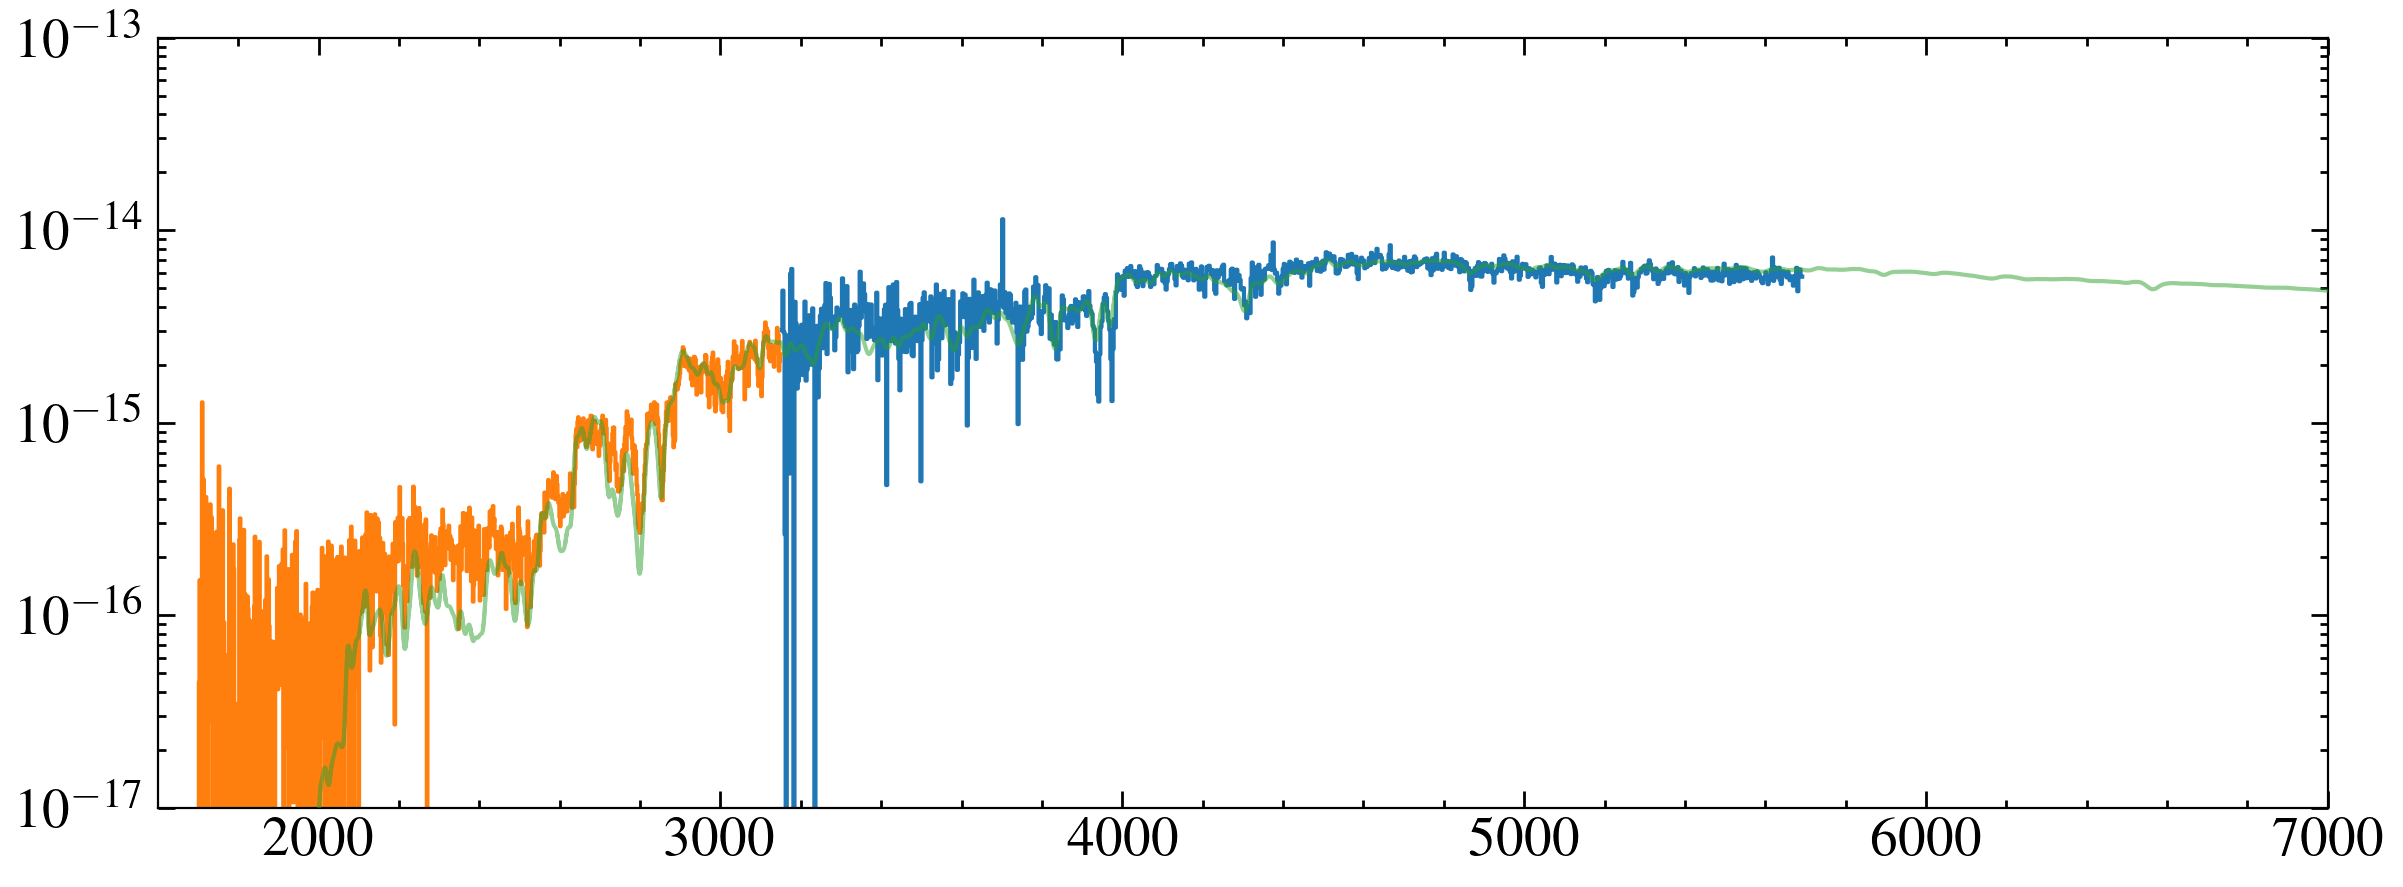

In [15]:
from scipy.optimize import leastsq
from dust_extinction.parameter_averages import F99

def residuals(scale, f, mf):
    return f - mf/scale

pmask = (pw > 2000) & (pw < 1e4)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 500)


fig, ax = plt.subplots()



ext = F99(Rv=3.1)

rednuv = ext.extinguish(w_nuv*u.AA, Ebv = 0.125)
redopt = ext.extinguish(w_opt*u.AA, Ebv=0.125)



ax.step(w_opt, f_opt/redopt, where='mid')
ax.step(w_nuv, f_nuv/rednuv, where='mid')

pffit = interp1d(pwi, pfi, fill_value='extrapolate')(w_opt)
scale = leastsq(residuals, 1., args=(f_opt/redopt, pffit))[0]
print(1/scale)
ax.step(pwi, pfi/scale, where='mid', zorder=10, alpha=0.5)
# ax.step(pwi, pfi, where='mid', zorder=10, alpha=0.5)





ax.set_yscale('log')
ax.set_ylim(1e-17, 1e-13)
ax.set_xlim(1600, 7000)

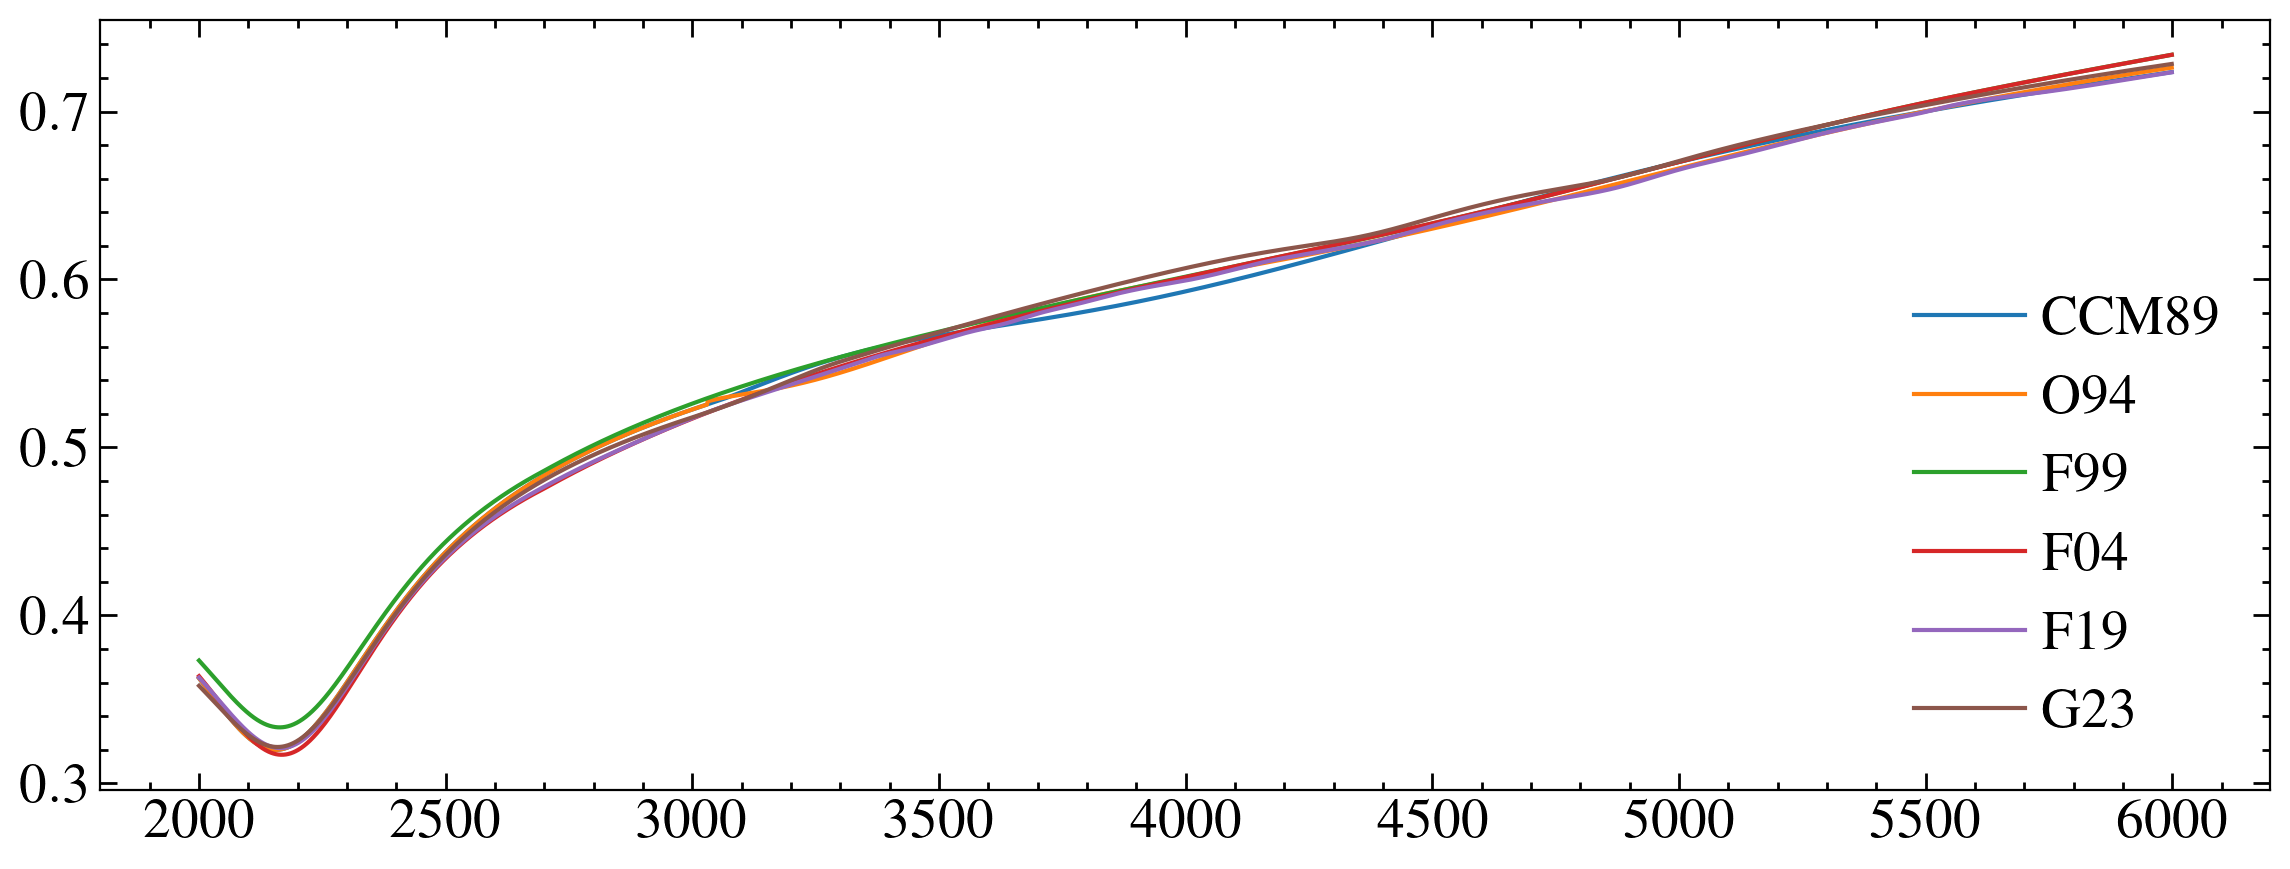

In [16]:

from dust_extinction.parameter_averages import (CCM89, O94, F99, F04,
                                                VCG04, GCC09, M14, F19, D22,
                                                G23)

models = [CCM89, O94, F99, F04, F19, G23]

w = np.arange(2000, 6000, 1)*u.AA
for mod in models: 
    ext = mod(Rv=3.1)
    red = ext.extinguish(w, Ebv = 0.125)
    plt.plot(w, red, label=ext.__class__.__name__)
plt.legend()
    

Scale to NUV flux or Mg ii lines?

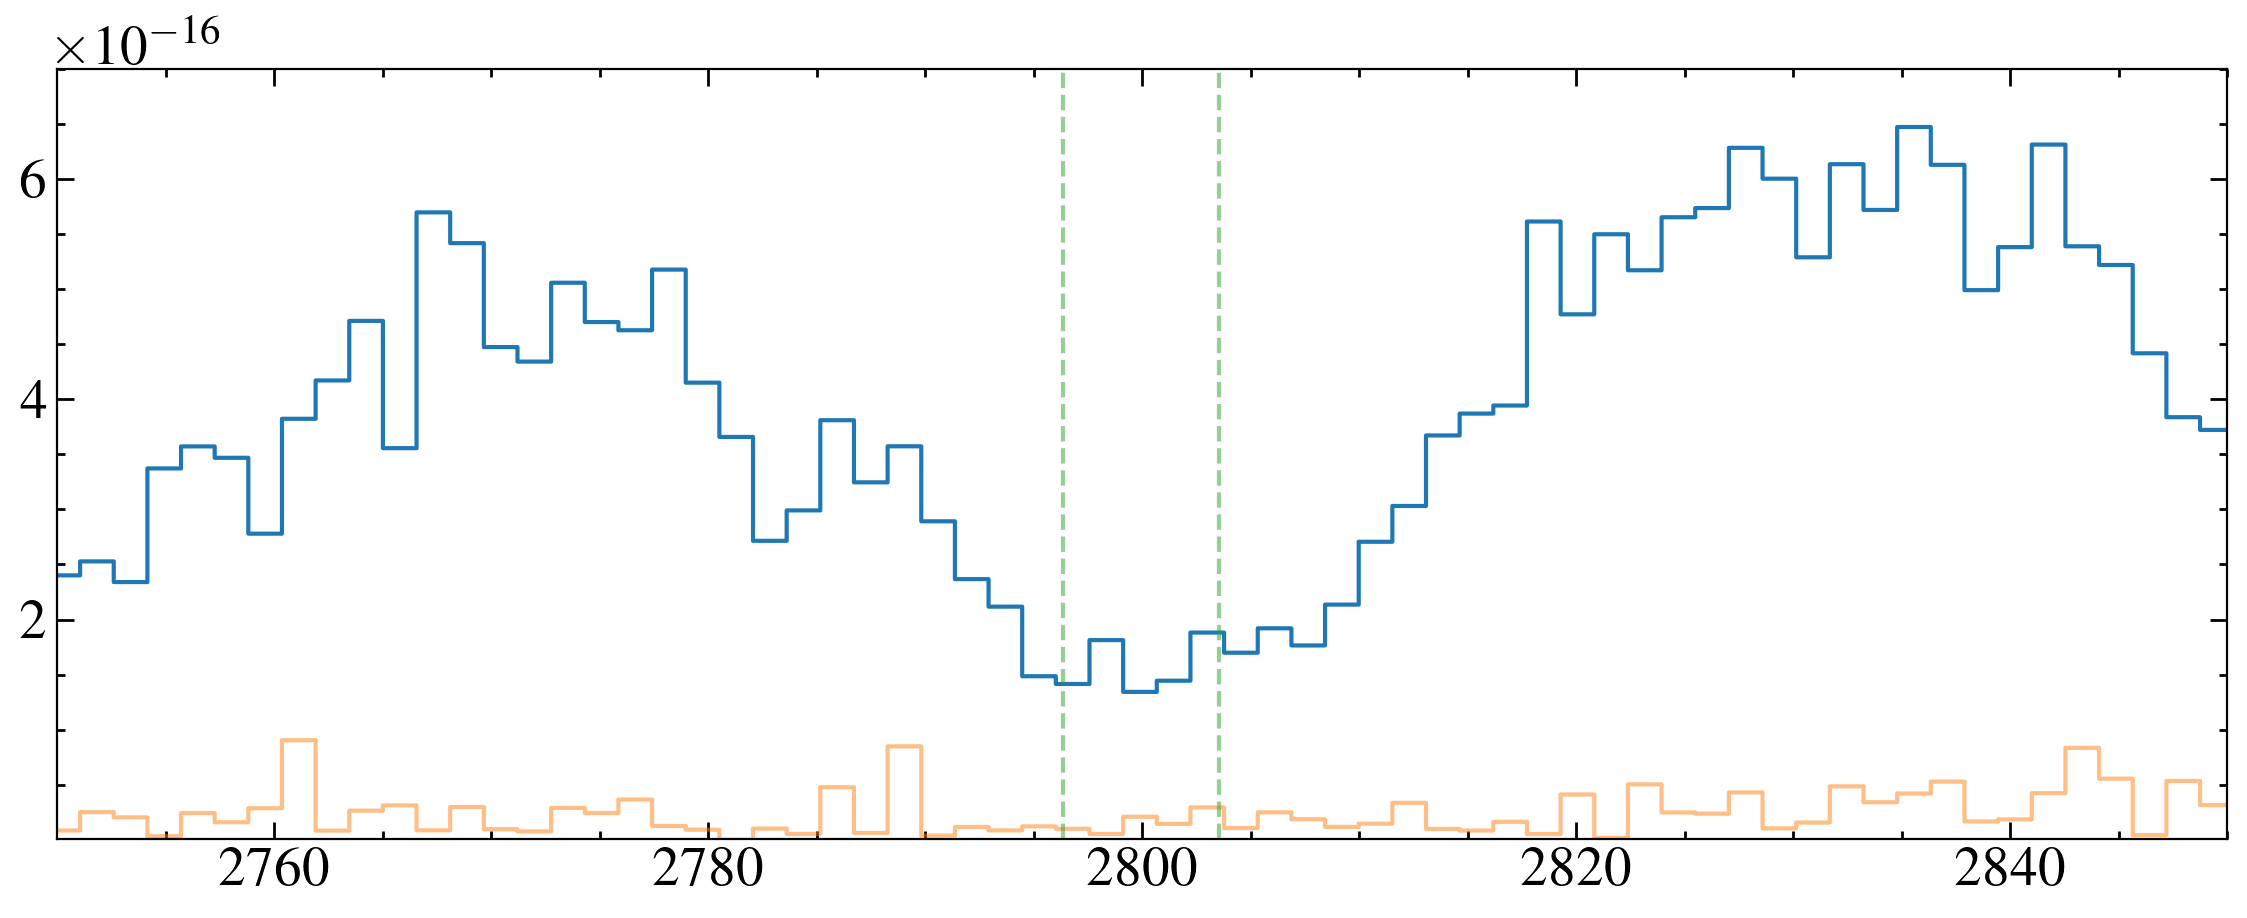

In [17]:
fig, ax = plt.subplots()

ax.step(w_nuv, f_nuv, where='mid')
ax.step(w_nuv, e_nuv, where='mid', alpha=0.5)
ax.set_xlim(2750, 2850)
ax.set_ylim(0.1e-17, 0.7e-15)

mg2 = [2796.352, 2803.53]
[ax.axvline(line, ls='--', c='C2', alpha=0.5) for line in mg2]


Mg II lines gone because it's far away?

In [18]:
kdata = fits.getdata('draft_hlsp/kap1cet/hlsp_muscles_multi_multi_kap1cet_broadband_v1_var-res-sed.fits', 1)
kw, kf, ke = kdata['WAVELENGTH'], kdata['FLUX'], kdata['ERROR']


In [45]:
# fig, ax = plt.subplots(nrows=2, figsize=(12, 9), sharex=True, sharey=True)

# d_kap = 9.2762

# dscale = (d_kap/distance)**2
# print(dscale)

# kwi, kfi = pp.smear(kw, kf, 1000)



# ax[0].step(w_opt, f_opt/redopt, where='mid', label = 'G430L')
# ax[1].step(w_opt, f_opt, where='mid')
# ax[0].step(w_nuv, f_nuv/rednuv, where='mid', label ='G230L' )
# ax[1].step(w_nuv, f_nuv, where='mid')


# # ax.step(pwi, pfi/scale, where='mid', zorder=10, alpha=0.5)
# # ax.step(pwi, pfi, where='mid', zorder=10, alpha=0.5)

# # ax.step(kwi, kfi*1.e-4, where='mid', alpha = 0.5, zorder=10)
# ax[0].step(kwi, kfi*dscale, where='mid', alpha = 0.7, zorder=10, label = 'Kap1 Cet (distance scaled)')
# ax[1].step(kwi, kfi*dscale, where='mid', alpha = 0.7, zorder=10)
# # ax.step(kw, kf*dscale, where='mid', alpha = 0.5, zorder=10)

# ax[0].set_title('With dereddening (Ebv = 0.125)')
# ax[1].set_title('No dereddening')


# ax[0].set_yscale('log')
# ax[0].set_ylim(2e-18, 2e-14)
# ax[0].set_xlim(1200, 5999)

# ax[0].legend(loc=4, frameon=True)

# bigax = fig.add_subplot(111, frame_on=False)
# bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
# bigax.set_xlabel('Wavelength (\AA)')
# bigax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', labelpad=30)

# fig.tight_layout()
# fig.savefig('plots/k51_v_k1c.pdf')

Big mismatch in the NUV. How far down do we beleive in K51s NUV?

(0.0, 100.0)

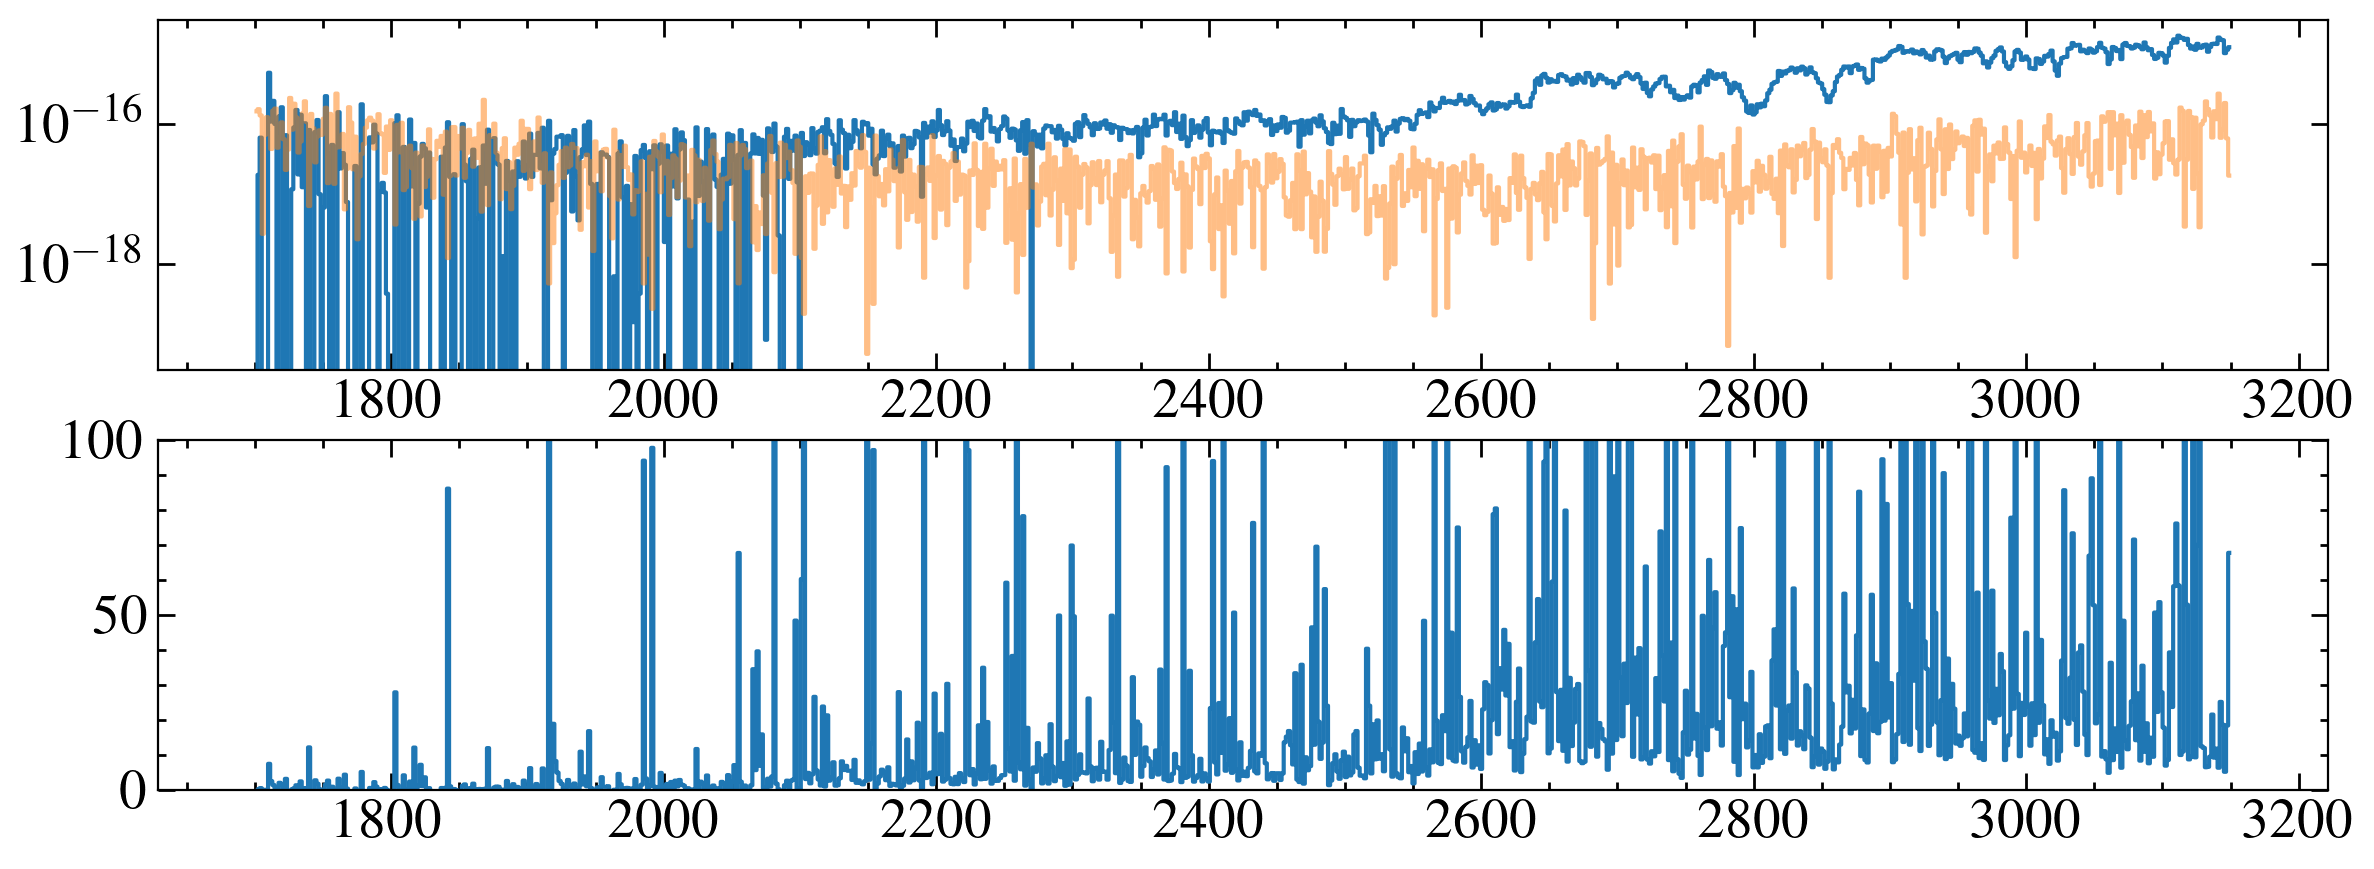

In [20]:
fig, ax = plt.subplots(nrows=2)

ax[0].step(w_nuv, f_nuv, where='mid')
ax[0].step(w_nuv, e_nuv, where='mid', alpha=0.5)
ax[0].set_yscale('log')
# ax.set_xlim(2770, 2830)
# ax.set_ylim(0.1e-15, 0.6e-15)

# mg2 = [2796.352, 2803.53]
# [ax.axvline(line, ls='--', c='C2', alpha=0.5) for line in mg2]

ax[1].step(w_nuv, f_nuv/e_nuv, where='mid')
ax[1].set_ylim(0, 100)

Scale to that flat bit 2100 - 2500 ish? Can detect with Swift in ~1000s, worth a TOO. Got a UVM2 image..

In [25]:
uvotpath = '/media/david/2tb_ext_hd/hddata/meats/swift/kepler-51/kepler_51_uvm2_phot.fits'
uvot = fits.getdata(uvotpath,1 )
# uvot.names
print(uvot['AB_FLUX_AA'], uvot['AB_FLUX_AA_ERR'])
uvot_w = 2245.03

[6.643455e-17] [1.4825738e-17]


Berger+19 has different Av = 0.197

In [47]:
0.197/3.1

0.0635483870967742

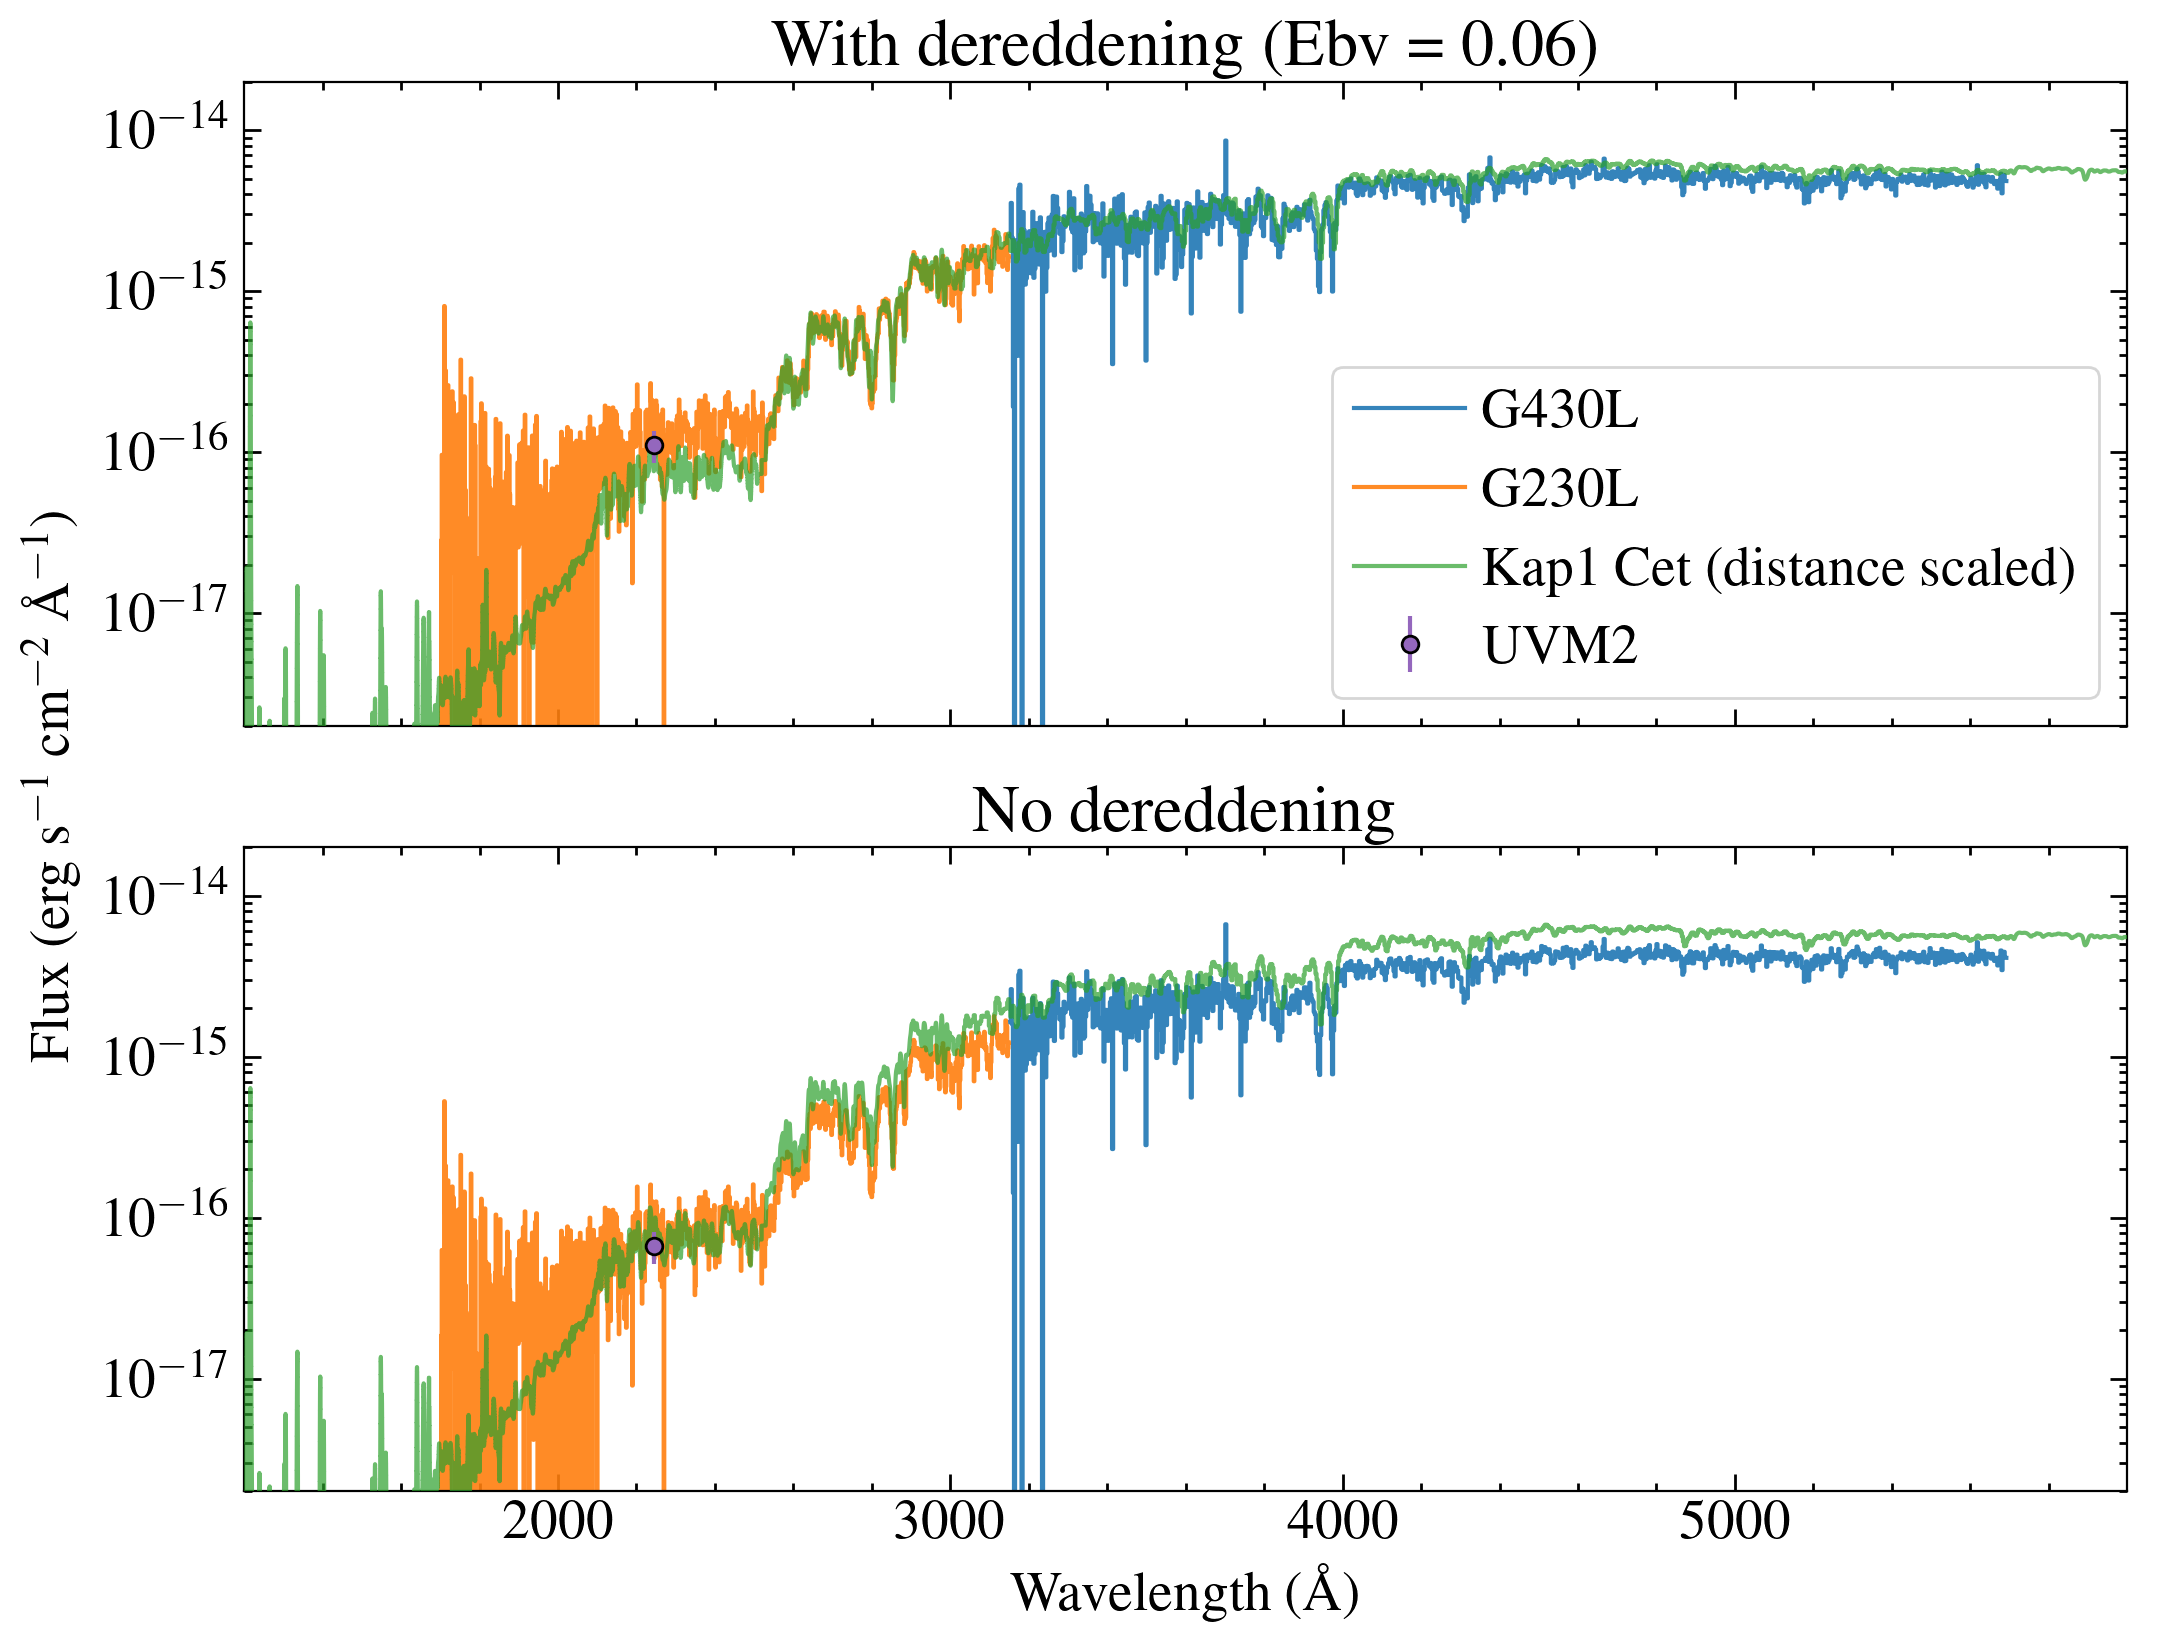

In [63]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 9), sharex=True, sharey=True)

d_kap = 9.2762

dscale = (d_kap/distance)**2
# print(dscale)

kwi, kfi = pp.smear(kw, kf, 2000)

ebv = 0.06

ext = F99(Rv=3.1)

rednuv = ext.extinguish(w_nuv*u.AA, Ebv = ebv)
redopt = ext.extinguish(w_opt*u.AA, Ebv= ebv)


ax[0].step(w_opt, f_opt/redopt, where='mid', label = 'G430L', alpha=0.9)
ax[1].step(w_opt, f_opt, where='mid', alpha=0.9)
ax[0].step(w_nuv, f_nuv/rednuv, where='mid', label ='G230L' , alpha=0.9)
ax[1].step(w_nuv, f_nuv, where='mid', alpha=0.9)

#swift
reduvot = ext.extinguish(uvot_w*u.AA, Ebv = ebv)
ax[0].errorbar(uvot_w, uvot['AB_FLUX_AA']/reduvot, yerr= uvot['AB_FLUX_AA_ERR']/reduvot, marker='o', markeredgecolor = 'k', c= 'C4', zorder=20, label = 'UVM2', ls='none')
ax[1].errorbar(uvot_w, uvot['AB_FLUX_AA'], yerr= uvot['AB_FLUX_AA_ERR'], marker='o', markeredgecolor = 'k', c= 'C4', zorder=20, ls='none')


# ax.step(pwi, pfi/scale, where='mid', zorder=10, alpha=0.5)
# ax.step(pwi, pfi, where='mid', zorder=10, alpha=0.5)

# ax.step(kwi, kfi*1.e-4, where='mid', alpha = 0.5, zorder=10)
ax[0].step(kwi, kfi*dscale, where='mid', alpha = 0.7, zorder=10, label = 'Kap1 Cet (distance scaled)')
ax[1].step(kwi, kfi*dscale, where='mid', alpha = 0.7, zorder=10)
# ax.step(kw, kf*dscale, where='mid', alpha = 0.5, zorder=10)

ax[0].set_title('With dereddening (Ebv = {})'.format(ebv))
ax[1].set_title('No dereddening')


ax[0].set_yscale('log')
ax[0].set_ylim(2e-18, 2e-14)
ax[0].set_xlim(1200, 5999)

ax[0].legend(loc=4, frameon=True)

bigax = fig.add_subplot(111, frame_on=False)
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
bigax.set_xlabel('Wavelength (\AA)')
bigax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', labelpad=30)

fig.tight_layout()
fig.savefig('plots/k51_v_k1c_swift.pdf')

(2e-17, 5.7365405487716756e-15)

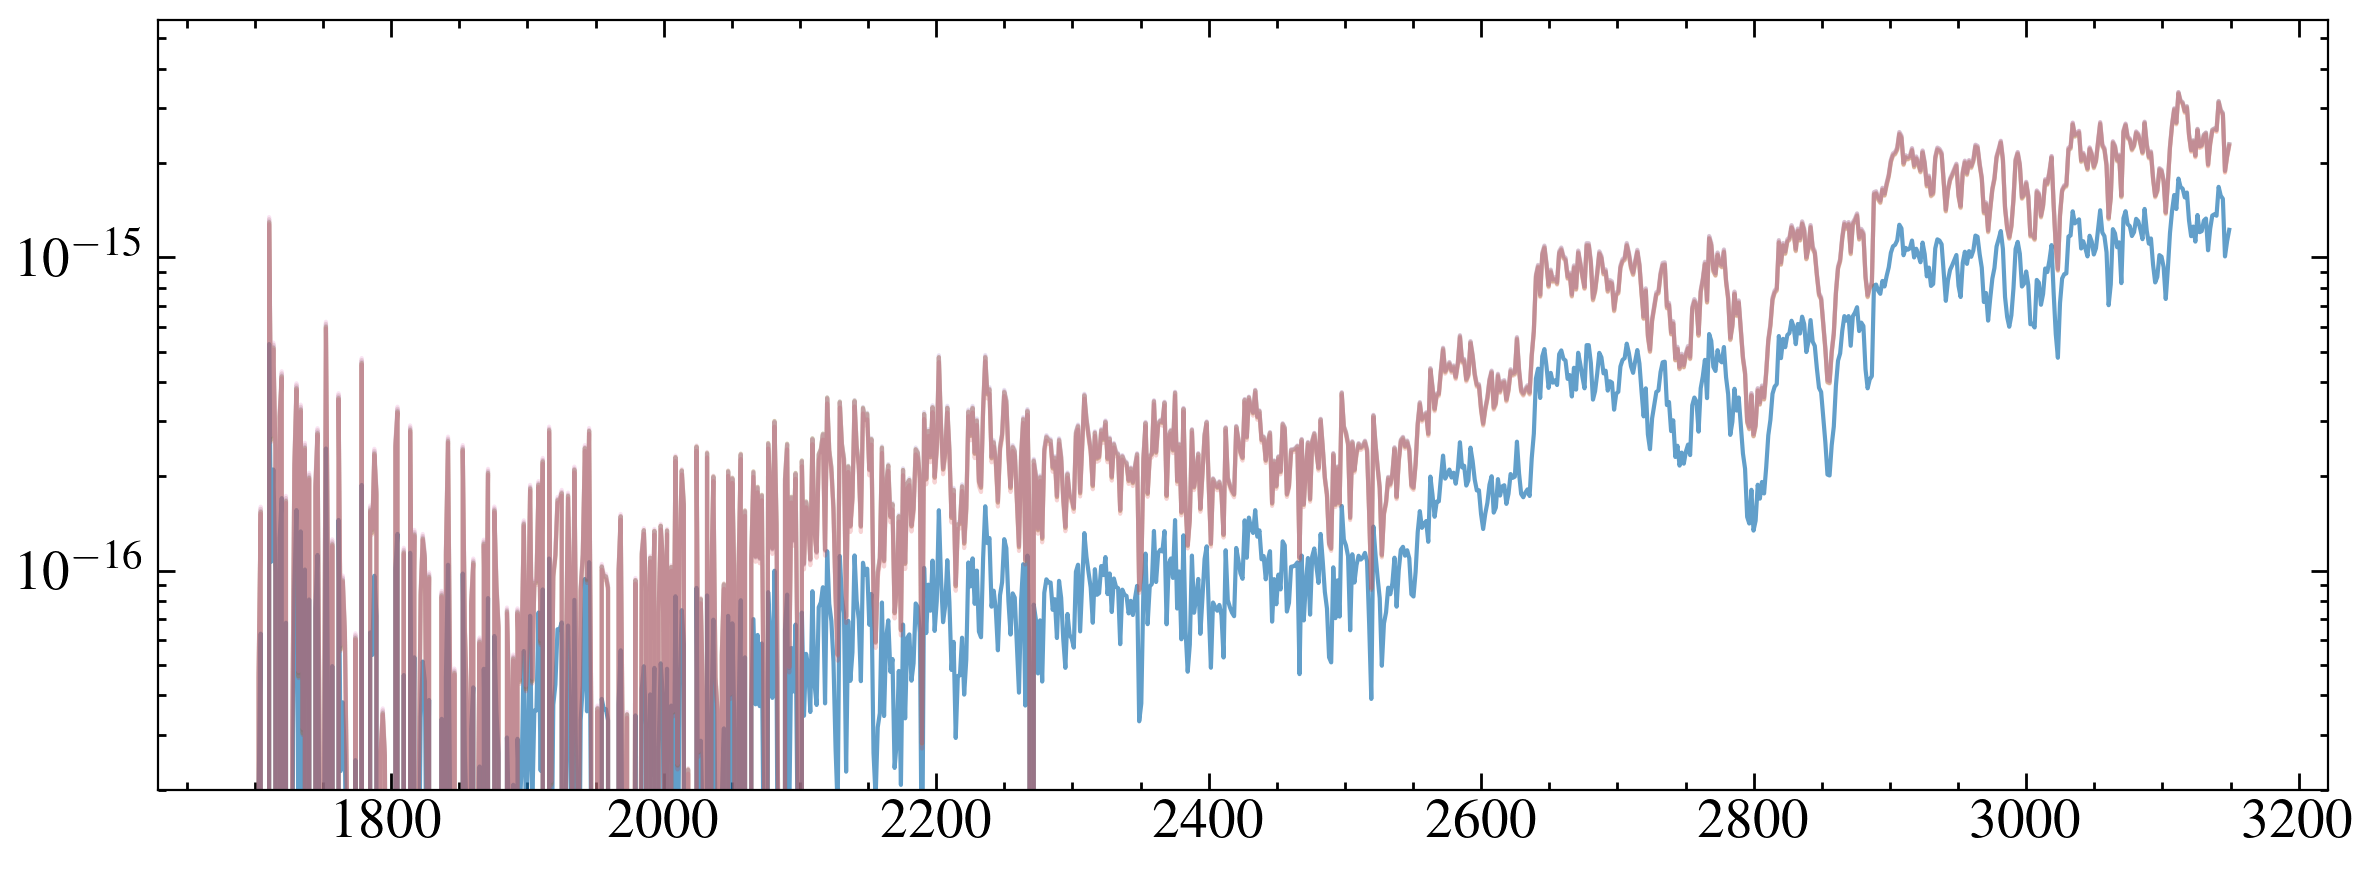

In [44]:

models = [CCM89, O94, F99, F04, F19, G23]

plt.plot(w_nuv, f_nuv, alpha=0.7)

for mod in models: 
    ext = mod(Rv=3.1)
    red = ext.extinguish(w_nuv*u.AA, Ebv = 0.125)
    plt.plot(w_nuv, f_nuv/red, alpha=0.2)
plt.yscale('log') 
plt.ylim(2e-17)